# Advanced Game Analysis

### **Part Two:** Visualizations for the Cognitive Microscope (1/2)

<h1> Análisis Avanzado de Partidas</h1>
<h3> <strong>Segunda parte:</strong> Gráficos para el microscopio cognitivo (1/2)</h3>

## 0. Carga de librerías necesarias

In [1]:
# =========================
# Módulos estándar de Python
# =========================
import re
import builtins
from pathlib import Path
from ast import literal_eval

# =========================
# Datos y cálculo
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualización (Matplotlib)
# =========================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

# =========================
# Visualización (Seaborn)
# =========================
import seaborn as sns

# =========================
# Interpolación / SciPy
# =========================
from scipy.interpolate import PchipInterpolator

# =========================
# Jupyter / Display
# =========================
from IPython.display import display, Markdown

# =========================
# Ajedrez
# =========================
import chess

## 1. Carga del dataframe (filtramos solo los jugadores_objetivo)

In [2]:

# --- Configuración de carpeta y jugadores objetivo ---
carpeta_parquets = Path("./analizadas_grupo")

jugadores_objetivo = [
    "Carlsen,M", "Nakamura,Hi", "Nepomniachtchi,I", "Caruana,F", "Lai,Duc Minh", 
    "Niemann,Hans Moke", "Firouzja,Alireza", "Vlassov,N", "Sarana,A",
    "Rustemov,A", "Andreikin,D", "Bluebaum,M", "Zhigalko,S", "Bortnyk,Olexandr"
]

# --- Leer y filtrar solo partidas de los jugadores objetivo ---
df_previo = pd.concat(
    [
        pd.read_parquet(p).query("jugador in @jugadores_objetivo")
        for p in carpeta_parquets.glob("*.parquet")
    ],
    ignore_index=True
)

print(f"Partidas cargadas (jugadores objetivo): {len(df_previo)}")

# --- Normalización de nombres ---
# Diccionario de reemplazo
mapa_nombres = {
    "Lai,Duc Minh": "Lai,D",
    "Niemann,Hans Moke": "Niemann,H",
    "Firouzja,Alireza": "Firouzja,A",
    "Nakamura,Hi": "Nakamura,H",
    "Bortnyk,Olexandr": "Bortnyk,O"
}

# Verificamos que las columnas existen antes de reemplazar
for col in ["jugador", "rival"]:
    if col in df_previo.columns:
        df_previo[col] = df_previo[col].replace(mapa_nombres)

# --- Guardar resultado final ---
df_raw = df_previo.copy()

print("Nombres normalizados y DataFrame final creado como 'df_raw'")
#print(f"Columnas disponibles: {list(df_raw.columns)}")


Partidas cargadas (jugadores objetivo): 9361
Nombres normalizados y DataFrame final creado como 'df_raw'


In [3]:
#df_raw.to_csv("mi_dataframe.csv", index=False)

## 2. Rendimiento general de cada jugador

In [4]:
# Lista de jugadores objetivo
#jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Nepomniachtchi,I", "Caruana,F", "Lai,D", "Niemann,H",  
#                      "Firouzja,A", "Vlassov,N", "Sarana,A", "Rustemov,A", "Andreikin,D",  "Bluebaum,M",
#                      "Zhigalko,S", "Bortnyk,O"]

jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Lai,D", "Sarana,A","Zhigalko,S", "Bortnyk,O"]

# Filtrar partidas de jugadores objetivo
df_objetivo = df_raw[df_raw["jugador"].isin(jugadores_objetivo)]

# Separar por color
df_blancas = df_objetivo[df_objetivo["color"] == "W"]
df_negras = df_objetivo[df_objetivo["color"] == "B"]

In [5]:
print(f"Partidas con blancas (jugadores objetivo): {len(df_blancas)}")
print(f"Partidas con negras (jugadores objetivo): {len(df_negras)}")

Partidas con blancas (jugadores objetivo): 2191
Partidas con negras (jugadores objetivo): 2118


### 2.1 Rendimiento global (ambos colores)

In [6]:
import pandas as pd

# Crear columnas auxiliares para cada resultado
df_resultados = df_objetivo.copy()
df_resultados["victoria"] = (df_resultados["resultados"] == 1.0).astype(int)
df_resultados["empate"]   = (df_resultados["resultados"] == 0.5).astype(int)
df_resultados["derrota"]  = (df_resultados["resultados"] == 0.0).astype(int)

# Agrupar y calcular estadísticas
estadisticas = (
    df_resultados
    .groupby("jugador", as_index=False)
    .agg(
        Partidas=("resultados", "count"),
        Promedio_de_Resultado=("resultados", "mean"),
        Victorias_pct=("victoria", lambda x: 100 * x.sum() / len(x)),
        Tablas_pct=("empate", lambda x: 100 * x.sum() / len(x)),
        Derrotas_pct=("derrota", lambda x: 100 * x.sum() / len(x))
    )
)

# Redondear columnas numéricas
estadisticas = estadisticas.round({
    "Promedio_de_Resultado": 2,
    "Victorias_pct": 2,
    "Tablas_pct": 2,
    "Derrotas_pct": 2
})

# Ordenar por Promedio de Resultado descendente
estadisticas_ordenadas = estadisticas.sort_values(by="Promedio_de_Resultado", ascending=False)

# Mostrar resultados
print(estadisticas_ordenadas)


      jugador  Partidas  Promedio_de_Resultado  Victorias_pct  Tablas_pct  \
1   Carlsen,M       580                   0.84          76.72       14.31   
3  Nakamura,H       689                   0.80          72.28       16.40   
0   Bortnyk,O       813                   0.74          68.39       10.82   
4    Sarana,A       969                   0.73          65.53       15.07   
5  Zhigalko,S       652                   0.72          66.72       10.89   
2       Lai,D       606                   0.52          47.85        8.58   

   Derrotas_pct  
1          8.97  
3         11.32  
0         20.79  
4         19.40  
5         22.39  
2         43.56  


### 2.2 Rendimiento global (por color)

In [7]:
import pandas as pd

# --- Función auxiliar en pandas ---
def calcular_estadisticas_por_color(df_color: pd.DataFrame) -> pd.DataFrame:
    # Asegurar tipo numérico por si viene como string
    df_aux = df_color.copy()
    df_aux["resultados"] = pd.to_numeric(df_aux["resultados"], errors="coerce")

    # Columnas auxiliares
    df_aux["victoria"] = (df_aux["resultados"] == 1.0).astype(int)
    df_aux["empate"]   = (df_aux["resultados"] == 0.5).astype(int)
    df_aux["derrota"]  = (df_aux["resultados"] == 0.0).astype(int)

    # Agrupar y calcular métricas
    estadisticas = (
        df_aux
        .groupby("jugador", as_index=False)
        .agg(
            Partidas=("resultados", "count"),
            Promedio_de_Resultado=("resultados", "mean"),
            Victorias_pct=("victoria", lambda x: 100 * x.sum() / len(x)),
            Tablas_pct=("empate",   lambda x: 100 * x.sum() / len(x)),
            Derrotas_pct=("derrota",lambda x: 100 * x.sum() / len(x)),
        )
    )

    # Redondeos
    estadisticas = estadisticas.round({
        "Promedio_de_Resultado": 2,
        "Victorias_pct": 2,
        "Tablas_pct": 2,
        "Derrotas_pct": 2
    })

    # Ordenar por promedio descendente
    return estadisticas.sort_values(by="Promedio_de_Resultado", ascending=False)

# --- Cálculo por color ---
estadisticas_blancas = calcular_estadisticas_por_color(df_blancas)
estadisticas_negras  = calcular_estadisticas_por_color(df_negras)

# --- Mostrar resultados ---
print("Estadísticas con blancas:")
print(estadisticas_blancas.to_string(index=False))

print("\nEstadísticas con negras:")
print(estadisticas_negras.to_string(index=False))


Estadísticas con blancas:
   jugador  Partidas  Promedio_de_Resultado  Victorias_pct  Tablas_pct  Derrotas_pct
 Carlsen,M       299                   0.83          76.59       13.38         10.03
Nakamura,H       347                   0.82          73.49       17.29          9.22
 Bortnyk,O       417                   0.75          70.50        9.83         19.66
Zhigalko,S       328                   0.74          68.60       11.59         19.82
  Sarana,A       489                   0.73          66.05       13.70         20.25
     Lai,D       311                   0.53          48.55        8.36         43.09

Estadísticas con negras:
   jugador  Partidas  Promedio_de_Resultado  Victorias_pct  Tablas_pct  Derrotas_pct
 Carlsen,M       281                   0.85          76.87       15.30          7.83
Nakamura,H       342                   0.79          71.05       15.50         13.45
  Sarana,A       480                   0.73          65.00       16.46         18.54
 Bortnyk,O   

### 2.3 Rendimiento general de cada jugador por color (decaimiento exponencial)
Refleja mejor el "estado de forma" actual.

- Se asigna como fecha de referencia la más reciente.
- Se calcula la diferencia en `días` entre la fecha de la partida y la fecha de referencia.
- Se devuelve una lista de pesos [$w_1$, $w_2$,$\ldots$] donde cada peso es $$w_i=e^{-\lambda \cdot \text{días} }$$
  donde $\lambda$ es el factor de decaimiento que se quiera indicar ($\lambda=0$ no influyen las fechas). 
- La lista de pesos se devuelve normalizada ($w_i\in[0,1]$ y $\sum w_i=1$).

In [8]:
# Parámetro de decaimiento
lambda_ = 0.01

# Filtrar por color (pandas)
df_blancas = df_objetivo[df_objetivo["color"] == "W"].copy()
df_negras  = df_objetivo[df_objetivo["color"] == "B"].copy()

# Función para aplicar a cada grupo (jugador)
def calcular_estadisticas_ponderadas(grupo: pd.DataFrame) -> pd.DataFrame:
    if grupo.empty:
        return pd.DataFrame([{
            "jugador": None,
            "Partidas": 0,
            "Promedio Ponderado": np.nan,
            "Victorias (%)": np.nan,
            "Tablas (%)": np.nan,
            "Derrotas (%)": np.nan
        }])

    # Tipos correctos
    g = grupo.copy()
    g["fechas"] = pd.to_datetime(g["fechas"], errors="coerce")
    g["resultados"] = pd.to_numeric(g["resultados"], errors="coerce")

    # Fechas válidas
    fechas_validas = g["fechas"].notna()
    if not fechas_validas.any():
        # Sin fechas válidas: ponderación uniforme
        pesos = np.ones(len(g)) / len(g)
    else:
        fecha_max = g.loc[fechas_validas, "fechas"].max()
        dias = (fecha_max - g["fechas"]).dt.days
        dias = dias.fillna(dias.max())  # si alguna fecha es NaT, darle el peor (más antiguo)
        pesos = np.exp(-lambda_ * dias.values)
        # Normalizar pesos (evitar división por cero)
        if pesos.sum() > 0:
            pesos = pesos / pesos.sum()
        else:
            pesos = np.ones(len(g)) / len(g)

    # Resultados válidos
    mask_valid = g["resultados"].notna().values
    if mask_valid.any():
        prom_ponderado = np.average(g.loc[mask_valid, "resultados"].values,
                                    weights=pesos[mask_valid])
        victorias = ( (g["resultados"].values == 1.0) * pesos ).sum()
        empates   = ( (g["resultados"].values == 0.5) * pesos ).sum()
        derrotas  = ( (g["resultados"].values == 0.0) * pesos ).sum()
    else:
        prom_ponderado = np.nan
        # con resultados todos NaN, las tasas ponderadas no tienen sentido
        victorias = empates = derrotas = np.nan

    return pd.DataFrame([{
        "jugador": g["jugador"].iloc[0],
        "Partidas": len(g),
        "Promedio Ponderado": builtins.round(prom_ponderado, 2) if pd.notna(prom_ponderado) else np.nan,
        "Victorias (%)": builtins.round(100 * victorias, 2) if pd.notna(victorias) else np.nan,
        "Tablas (%)": builtins.round(100 * empates, 2) if pd.notna(empates) else np.nan,
        "Derrotas (%)": builtins.round(100 * derrotas, 2) if pd.notna(derrotas) else np.nan
    }])

# Aplicar por jugador con pandas (equivalente a applyInPandas)
estadisticas_blancas_pond = (
    df_blancas
    .groupby("jugador", group_keys=False)
    .apply(calcular_estadisticas_ponderadas)
    .reset_index(drop=True)
    .sort_values("Promedio Ponderado", ascending=False)
)

estadisticas_negras_pond = (
    df_negras
    .groupby("jugador", group_keys=False)
    .apply(calcular_estadisticas_ponderadas)
    .reset_index(drop=True)
    .sort_values("Promedio Ponderado", ascending=False)
)

# Mostrar
print("Estadísticas con blancas (ponderadas por fecha):")
print(estadisticas_blancas_pond.to_string(index=False))

print("\nEstadísticas con negras (ponderadas por fecha):")
print(estadisticas_negras_pond.to_string(index=False))


Estadísticas con blancas (ponderadas por fecha):
   jugador  Partidas  Promedio Ponderado  Victorias (%)  Tablas (%)  Derrotas (%)
 Carlsen,M       299                0.83          75.26       15.62          9.11
Nakamura,H       347                0.83          73.59       18.32          8.09
Zhigalko,S       328                0.72          65.98       12.01         22.01
  Sarana,A       489                0.72          66.16       12.51         21.33
 Bortnyk,O       417                0.68          63.25        9.98         26.77
     Lai,D       311                0.51          46.50        8.25         45.25

Estadísticas con negras (ponderadas por fecha):
   jugador  Partidas  Promedio Ponderado  Victorias (%)  Tablas (%)  Derrotas (%)
 Carlsen,M       281                0.84          76.61       15.74          7.65
Nakamura,H       342                0.77          67.21       18.94         13.85
  Sarana,A       480                0.70          61.35       17.05         21.60


C:\Users\pedro\AppData\Local\Temp\ipykernel_178092\3951161783.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calcular_estadisticas_ponderadas)
C:\Users\pedro\AppData\Local\Temp\ipykernel_178092\3951161783.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calcular_estadisticas_ponderadas)


### 2.4 Gráficas del rendimiento general de cada jugador por color

PySpark no puede generar gráficos directamente. Para graficar, necesitas convertir los datos de Spark a pandas, y luego usar matplotlib, como en local. Por tanto, se procesan los datos en Spark (eficiente y distribuido), convertimos los resultados a pandas (toPandas()) y graficamos localmente en Jupyter con matplotlib.

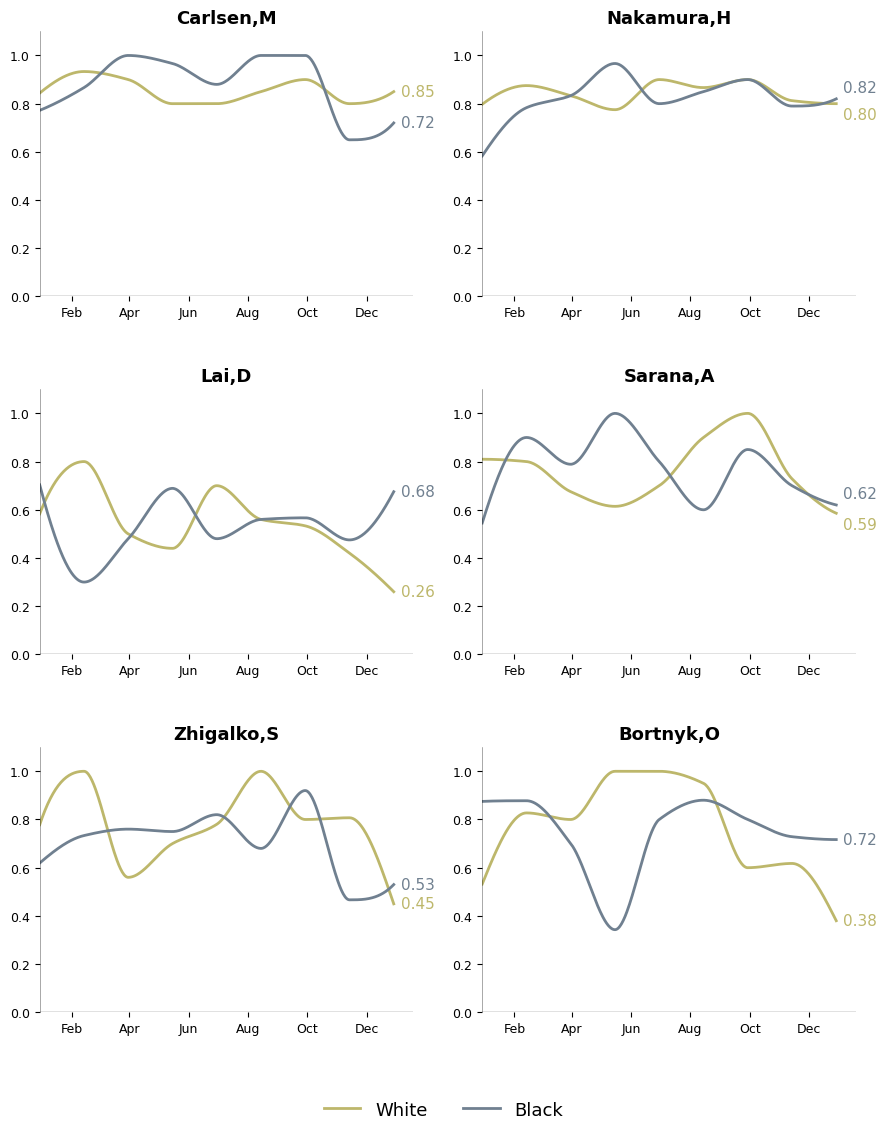

In [9]:
# Jugadores a mostrar
jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Lai,D",
                      "Sarana,A", "Zhigalko,S", "Bortnyk,O"]

ventana = 5

# --- Preprocesado (pandas) ---
df = df_raw.copy()
df["fechas"] = pd.to_datetime(df["fechas"], errors="coerce")

df_objetivo = (
    df.loc[:, ["jugador", "color", "fechas", "resultados"]]
      .query("jugador in @jugadores_objetivo")
      .dropna(subset=["fechas"])
)

# --- Gráfico ---
colores = {"W": "darkkhaki", "B": "slategray"}

n = len(jugadores_objetivo)
nrows, ncols = 3, 2  # filas x columnas

fig_w, fig_h = 4.5 * ncols, 4.0 * nrows
fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h))
axes = np.atleast_1d(axes).ravel()

# Fechas comunes
fechas_inicio = df_objetivo["fechas"].min()
fechas_fin = df_objetivo["fechas"].max()
fechas_referencia = pd.date_range(start=fechas_inicio, end=fechas_fin, periods=9)
x_base = mdates.date2num(fechas_referencia.to_pydatetime())

for i, jugador in enumerate(jugadores_objetivo):
    ax = axes[i]
    valores_finales = {}

    for color in ["W", "B"]:
        partidas = df_objetivo[
            (df_objetivo["jugador"] == jugador) & (df_objetivo["color"] == color)
        ].copy()
        if partidas.empty:
            continue

        partidas.sort_values("fechas", inplace=True)

        # media móvil
        partidas["media_movil"] = partidas["resultados"].rolling(
            window=ventana, min_periods=1
        ).mean()

        # promedio por día
        promedio_por_dia = partidas.groupby(
            "fechas", as_index=True
        )["media_movil"].mean()

        # alineamos a fechas_referencia
        serie = promedio_por_dia.reindex(
            fechas_referencia, method="nearest"
        ).interpolate()

        y = serie.values
        x = x_base

        # spline sin overshoot usando PCHIP
        if len(x) >= 4:
            interp = PchipInterpolator(x, y)
            x_nuevo = np.linspace(x.min(), x.max(), 400)
            y_suave = interp(x_nuevo)
            fechas_suaves = mdates.num2date(x_nuevo)

            ax.plot(
                fechas_suaves,
                y_suave,
                label=("White" if color == "W" else "Black"),
                color=colores[color],
                linewidth=2,
            )
            valores_finales[color] = (fechas_suaves[-1], y_suave[-1])

        # --- Etiquetas finales (sin intercambio: el mayor arriba) ---
        if "W" in valores_finales and "B" in valores_finales:
            f_w, y_w = valores_finales["W"]
            f_b, y_b = valores_finales["B"]
        
            diff = abs(y_w - y_b)
        
            # Sin separación horizontal (como querías)
            dx_w = dx_b = 5
        
            # Si están muy cerca, separa en vertical poniendo el mayor arriba
            if diff < 0.06:
                if y_w >= y_b:
                    dy_w, dy_b = 8, -8
                else:
                    dy_w, dy_b = -8, 8
            else:
                dy_w = dy_b = 0
        
            ax.annotate(
                f"{y_w:.2f}",
                xy=(f_w, y_w),
                xytext=(dx_w, dy_w),
                textcoords="offset points",
                fontsize=11,
                color=colores["W"],
                va="center",
                ha="left",
                clip_on=False,
                bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.65),
            )
            ax.annotate(
                f"{y_b:.2f}",
                xy=(f_b, y_b),
                xytext=(dx_b, dy_b),
                textcoords="offset points",
                fontsize=11,
                color=colores["B"],
                va="center",
                ha="left",
                clip_on=False,
                bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.65),
            )

    # --- Ejes y formato ---
    ax.set_title(jugador, fontsize=13, weight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xlim(fechas_inicio, fechas_fin + pd.Timedelta(days=20))
    ax.axhline(0, color="black", linewidth=1.0, alpha=0.6)
    ax.axvline(fechas_inicio, color="black", linewidth=0.4, alpha=0.6)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # <-- solo mes (sin año)
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="both", which="major", labelsize=9)

    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Ocultar subplots vacíos (si sobran)
for j in range(len(jugadores_objetivo), len(axes)):
    axes[j].axis("off")

# Leyenda global
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    if h:
        handles, labels = h, l
        break

if handles:
    fig.legend(
        handles,
        labels,
        loc="lower center",
        ncol=2,
        fontsize=13,
        frameon=False,
    )

plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.subplots_adjust(hspace=0.35)  # más separación vertical entre filas
plt.savefig("resultados_evolucion.png", dpi=400, bbox_inches="tight")
plt.show()


## 3. Estadísticas del rating ELO por jugador

In [10]:
# 1) Preprocesar en local (pandas)
df = df.copy()
df["fechas"] = pd.to_datetime(df["fechas"], errors="coerce")

#jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Nepomniachtchi,I", "Caruana,F", "Lai,D", "Niemann,H",  
#                      "Firouzja,A", "Vlassov,N", "Sarana,A", "Rustemov,A", "Andreikin,D",  "Bluebaum,M",
#                      "Zhigalko,S", "Bortnyk,O"]

jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Lai,D",
                      "Sarana,A", "Zhigalko,S", "Bortnyk,O"]


# 2) Filtrar jugadores objetivo
df_objetivo = df[df["jugador"].isin(jugadores_objetivo)].loc[:, ["jugador", "color", "fechas", "elo"]]

# 3) Separar por color
df_blancas = df_objetivo[df_objetivo["color"] == "W"].copy()
df_negras  = df_objetivo[df_objetivo["color"] == "B"].copy()

# 4) Estadísticas básicas por jugador (equivalente a Spark)
def calcular_estadisticas_elo(df_color: pd.DataFrame) -> pd.DataFrame:
    if df_color.empty:
        return pd.DataFrame(columns=["jugador", "Partidas", "Media", "Desv_Tipica", "Min", "Max"])
    g = df_color.copy()
    g["elo"] = pd.to_numeric(g["elo"], errors="coerce")  # asegurar numérico
    stats = (
        g.groupby("jugador", as_index=False)
         .agg(
            Partidas=("elo", "count"),
            Media=("elo", "mean"),
            Desv_Tipica=("elo", "std"),
            Min=("elo", "min"),
            Max=("elo", "max"),
         )
    )
    # Redondeo suave (ajústalo a gusto)
    stats[["Media","Desv_Tipica"]] = stats[["Media","Desv_Tipica"]].round(2)
    stats[["Min","Max"]] = stats[["Min","Max"]].round(0)
    # Ordenar por Media descendente (opcional)
    stats = stats.sort_values(by="Media", ascending=False, ignore_index=True)
    return stats

estadisticas_elo_blancas = calcular_estadisticas_elo(df_blancas)
estadisticas_elo_negras  = calcular_estadisticas_elo(df_negras)

# 5) Mostrar (opcional)
print("Estadísticas ELO con blancas:")
print(estadisticas_elo_blancas.to_string(index=False))

print("\nEstadísticas ELO con negras:")
print(estadisticas_elo_negras.to_string(index=False))


Estadísticas ELO con blancas:
   jugador  Partidas   Media  Desv_Tipica    Min    Max
 Carlsen,M       299 2836.40         3.09 2831.0 2840.0
Nakamura,H       347 2806.54         4.62 2802.0 2816.0
  Sarana,A       489 2679.21         8.48 2661.0 2713.0
 Bortnyk,O       417 2601.08         0.40 2601.0 2603.0
Zhigalko,S       328 2572.00         0.00 2572.0 2572.0
     Lai,D       311 2115.36        41.17 2072.0 2176.0

Estadísticas ELO con negras:
   jugador  Partidas   Media  Desv_Tipica    Min    Max
 Carlsen,M       281 2836.31         3.09 2831.0 2840.0
Nakamura,H       342 2806.65         4.46 2802.0 2816.0
  Sarana,A       480 2679.36         8.77 2661.0 2713.0
 Bortnyk,O       396 2601.09         0.42 2601.0 2603.0
Zhigalko,S       324 2572.00         0.00 2572.0 2572.0
     Lai,D       295 2113.95        41.34 2072.0 2176.0


In [11]:
# --- Asegurar formato y columnas ---
df = df.copy()
df["fechas"] = pd.to_datetime(df["fechas"], errors="coerce")
df["elo"] = pd.to_numeric(df["elo"], errors="coerce")

jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Lai,D",
                      "Sarana,A", "Zhigalko,S", "Bortnyk,O"]


# --- Filtrar jugadores de interés ---
df_objetivo = df[df["jugador"].isin(jugadores_objetivo)][["jugador", "elo"]].copy()

# --- Calcular estadísticas globales (sin distinguir color) ---
estadisticas_elo_global = (
    df_objetivo
    .groupby("jugador", as_index=False)
    .agg(
        Partidas=("elo", "count"),
        Media=("elo", "mean"),
        Desv_Tipica=("elo", "std"),
        Min=("elo", "min"),
        Max=("elo", "max")
    )
)

# --- Redondeo y orden ---
estadisticas_elo_global = estadisticas_elo_global.round({
    "Media": 2,
    "Desv_Tipica": 2,
    "Min": 0,
    "Max": 0
}).sort_values(by="Media", ascending=False, ignore_index=True)

# --- Mostrar resultado ---
print("Estadísticas globales de ELO (todas las partidas):")
print(estadisticas_elo_global.to_string(index=False))


Estadísticas globales de ELO (todas las partidas):
   jugador  Partidas   Media  Desv_Tipica    Min    Max
 Carlsen,M       580 2836.36         3.09 2831.0 2840.0
Nakamura,H       689 2806.59         4.54 2802.0 2816.0
  Sarana,A       969 2679.29         8.62 2661.0 2713.0
 Bortnyk,O       813 2601.09         0.41 2601.0 2603.0
Zhigalko,S       652 2572.00         0.00 2572.0 2572.0
     Lai,D       606 2114.67        41.23 2072.0 2176.0


## 4. Análisis de los errores

In [12]:
# =========================
# Errores normalizados (solo jugadores objetivo)
# =========================

# Lista de jugadores a analizar
jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Lai,D",
                      "Sarana,A", "Zhigalko,S", "Bortnyk,O"]


# Filtrar el DataFrame original
df_sel = df[df["jugador"].isin(jugadores_objetivo)].copy()

# Asegurar que las columnas necesarias existen y están limpias
for c in ["errores_leves", "errores", "errores_graves", "movimientos_total"]:
    if c in df_sel.columns:
        df_sel[c] = pd.to_numeric(df_sel[c], errors="coerce").fillna(0).astype(int)
    else:
        df_sel[c] = 0

# Agrupar por jugador y color
agr = (
    df_sel.groupby(["jugador", "color"], as_index=False)
    .agg(
        Partidas=("jugador", "count"),
        Movs=("movimientos_total", "sum"),
        Leves=("errores_leves", "sum"),
        Moderados=("errores", "sum"),
        Graves=("errores_graves", "sum"),
    )
)

# Totales y tasas normalizadas (por 100 movimientos)
agr["Total"] = agr["Leves"] + agr["Moderados"] + agr["Graves"]

agr["Leves/100mov"]     = np.where(agr["Movs"]>0, agr["Leves"]     / agr["Movs"] * 100, np.nan)
agr["Moderados/100mov"] = np.where(agr["Movs"]>0, agr["Moderados"] / agr["Movs"] * 100, np.nan)
agr["Graves/100mov"]    = np.where(agr["Movs"]>0, agr["Graves"]    / agr["Movs"] * 100, np.nan)
agr["Total/100mov"]     = np.where(agr["Movs"]>0, agr["Total"]     / agr["Movs"] * 100, np.nan)

# Redondear
for c in ["Leves/100mov", "Moderados/100mov", "Graves/100mov", "Total/100mov"]:
    agr[c] = agr[c].round(2)

# Reordenar columnas para visualización
cols_show = [
    "Partidas","Movs",
    "Leves","Moderados","Graves","Total",
    "Leves/100mov","Moderados/100mov","Graves/100mov","Total/100mov"
]
agr = agr[["jugador","color"] + cols_show]

# Ajustar opciones de pandas para que todo salga en una sola línea
pd.set_option("display.max_columns", None)   # mostrar todas las columnas
pd.set_option("display.expand_frame_repr", False)  # evitar saltos de línea
pd.set_option("display.colheader_justify", "center")  # centrar encabezados

# Tablas separadas por color
tbl_W = (
    agr[agr["color"]=="W"]
    .drop(columns=["color"])
    .set_index("jugador")
    .sort_values("Total/100mov", ascending=True)  # menos errores arriba
)

tbl_B = (
    agr[agr["color"]=="B"]
    .drop(columns=["color"])
    .set_index("jugador")
    .sort_values("Total/100mov", ascending=True)
)

# Mostrar resultados con gradiente de color en "Total/100mov"
display(Markdown("#### Errores normalizados jugando con **BLANCAS**"))
display(
    tbl_W.style
        .background_gradient(cmap="RdYlGn_r", subset=["Total/100mov"])  # Verde = mejor (menos errores)
        .format(precision=2)
)

display(Markdown("#### Errores normalizados jugando con **NEGRAS**"))
display(
    tbl_B.style
        .background_gradient(cmap="RdYlGn_r", subset=["Total/100mov"])
        .format(precision=2)
)


#### Errores normalizados jugando con **BLANCAS**

,Partidas,Movs,Leves,Moderados,Graves,Total,Leves/100mov,Moderados/100mov,Graves/100mov,Total/100mov
jugador,,,,,,,,,,
"Carlsen,M",299,13555,759,426,50,1235,5.60,3.14,0.37,9.11
"Nakamura,H",347,17584,987,801,126,1914,5.61,4.56,0.72,10.88
"Sarana,A",489,24153,1499,945,199,2643,6.21,3.91,0.82,10.94
"Bortnyk,O",417,19525,1411,828,131,2370,7.23,4.24,0.67,12.14
"Zhigalko,S",328,15777,1152,728,198,2078,7.30,4.61,1.25,13.17
"Lai,D",311,14863,1267,1027,307,2601,8.52,6.91,2.07,17.50


#### Errores normalizados jugando con **NEGRAS**

,Partidas,Movs,Leves,Moderados,Graves,Total,Leves/100mov,Moderados/100mov,Graves/100mov,Total/100mov
jugador,,,,,,,,,,
"Carlsen,M",281,12840,766,335,77,1178,5.97,2.61,0.60,9.17
"Nakamura,H",342,16329,1057,578,126,1761,6.47,3.54,0.77,10.78
"Sarana,A",480,24580,1500,978,220,2698,6.10,3.98,0.90,10.98
"Bortnyk,O",396,19868,1291,821,201,2313,6.50,4.13,1.01,11.64
"Zhigalko,S",324,15413,1071,688,232,1991,6.95,4.46,1.51,12.92
"Lai,D",295,13135,1122,893,258,2273,8.54,6.80,1.96,17.30


#### Misma representación pero gráficamente. Análisis gráfico por gravedad del error.

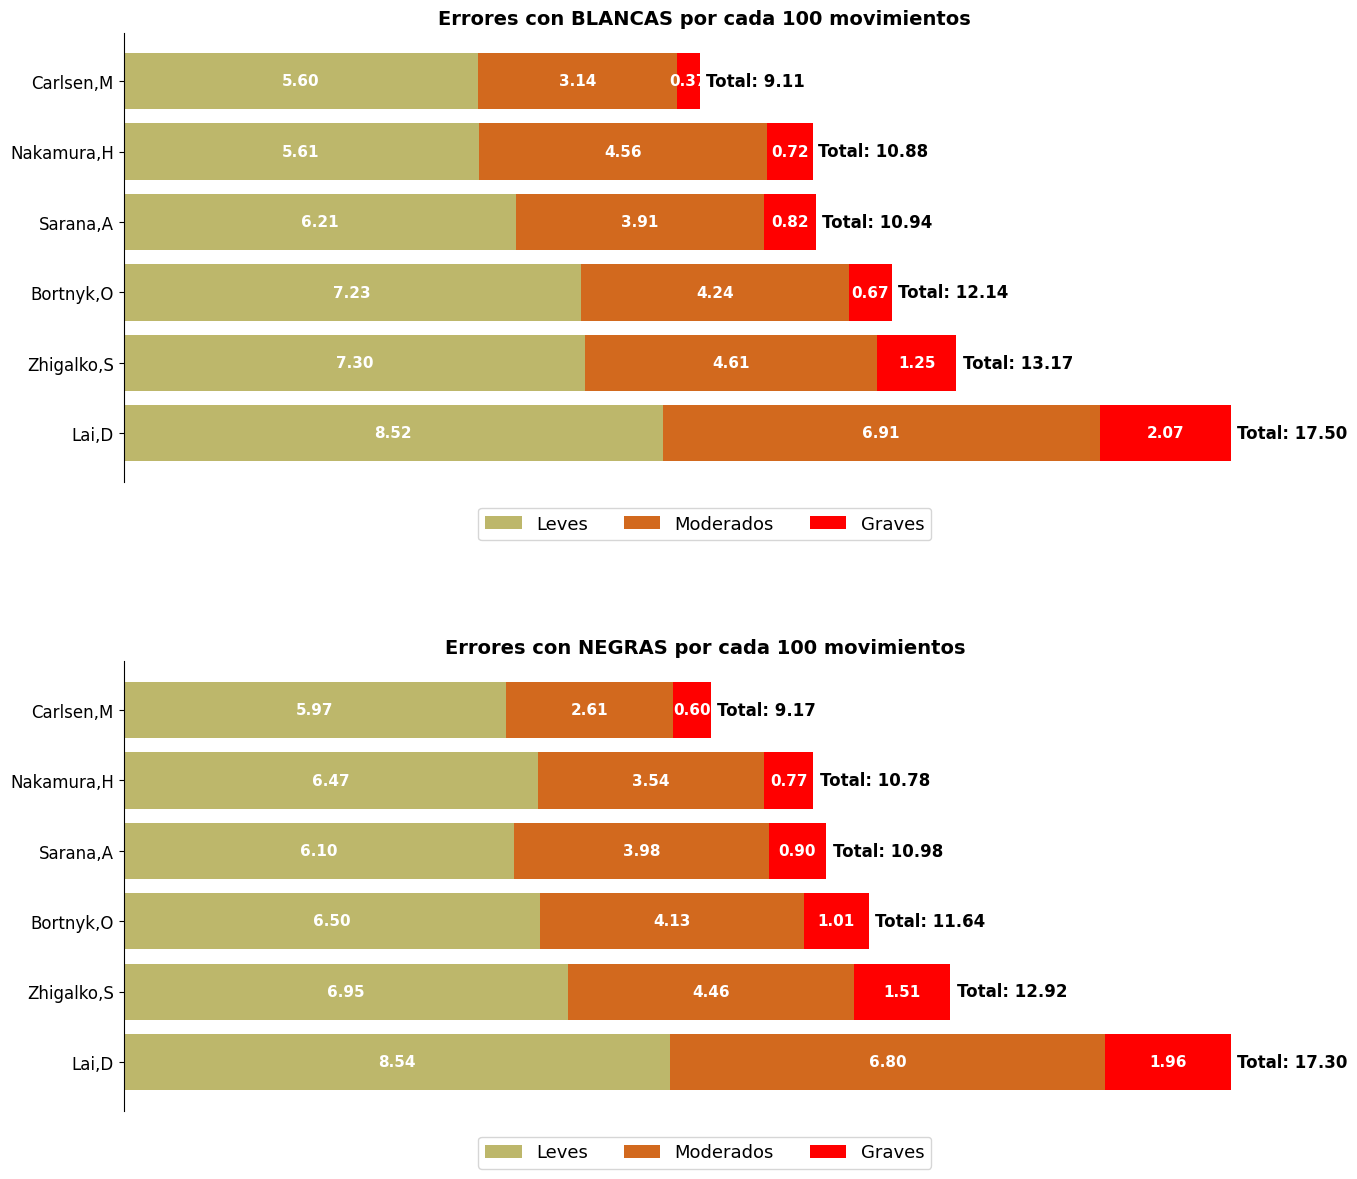

In [13]:
# ========= 0) (Opcional) filtra jugadores objetivo =========
# Deja la lista vacía para usar todos
jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Lai,D",
                      "Sarana,A", "Zhigalko,S", "Bortnyk,O"]


df_src = df.copy()
if jugadores_objetivo:
    df_src = df_src[df_src["jugador"].isin(jugadores_objetivo)].copy()

# Asegura columnas necesarias como enteros (o 0 si faltan)
for c in ["errores_leves", "errores", "errores_graves", "movimientos_total"]:
    if c not in df_src.columns:
        df_src[c] = 0
    df_src[c] = pd.to_numeric(df_src[c], errors="coerce").fillna(0).astype(int)

# ========= 1) Construir agregados por jugador y color (con movimientos) =========
agr100 = (
    df_src.groupby(["jugador", "color"], as_index=False)
    .agg(
        Partidas=("jugador", "count"),
        Movs=("movimientos_total", "sum"),
        Leves=("errores_leves", "sum"),
        Moderados=("errores", "sum"),
        Graves=("errores_graves", "sum"),
    )
)
agr100["Total"] = agr100["Leves"] + agr100["Moderados"] + agr100["Graves"]

# Tasas por CADA 100 MOVIMIENTOS
agr100["Leves/100mov"]     = np.where(agr100["Movs"]>0, agr100["Leves"]     / agr100["Movs"] * 100, np.nan)
agr100["Moderados/100mov"] = np.where(agr100["Movs"]>0, agr100["Moderados"] / agr100["Movs"] * 100, np.nan)
agr100["Graves/100mov"]    = np.where(agr100["Movs"]>0, agr100["Graves"]    / agr100["Movs"] * 100, np.nan)
agr100["Total/100mov"]     = np.where(agr100["Movs"]>0, agr100["Total"]     / agr100["Movs"] * 100, np.nan)

# Redondeo
for c in ["Leves/100mov","Moderados/100mov","Graves/100mov","Total/100mov"]:
    agr100[c] = agr100[c].round(2)

# ========= 2) Preparación por color para el gráfico =========
agr100_idx = agr100.set_index(["jugador","color"])

def preparar_datos_para_barras_100mov(df_idx: pd.DataFrame, color: str) -> pd.DataFrame:
    if color not in df_idx.index.get_level_values("color"):
        return pd.DataFrame()
    data = df_idx.xs(color, level="color")
    cols = ["Leves/100mov","Moderados/100mov","Graves/100mov","Total/100mov"]
    data = data[cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    data = data.sort_values("Total/100mov", ascending=True)
    return data

data_blancas = preparar_datos_para_barras_100mov(agr100_idx, "W")
data_negras  = preparar_datos_para_barras_100mov(agr100_idx, "B")

# ========= 3) Gráfico (dos paneles: Blancas / Negras) =========
fig = plt.figure(figsize=(15, 14))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.4)
axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

colores = {
    "Leves/100mov": "darkkhaki",
    "Moderados/100mov": "chocolate",
    "Graves/100mov": "red"
}

def agregar_etiquetas(ax, y_pos, data: pd.DataFrame, col_segmento: str, izquierda):
    izq = np.asarray(izquierda)
    vals = data[col_segmento].to_numpy()
    for i, y in enumerate(y_pos):
        v = float(vals[i])
        if v > 0.05:  # evita números en segmentos diminutos
            x = izq[i] + v/2.0
            ax.text(x, y, f"{v:.2f}", ha='center', va='center', fontsize=11, color="white", weight="bold")

for ax, data, titulo_color in zip(axes, [data_blancas, data_negras], ["BLANCAS", "NEGRAS"]):
    if data.empty:
        ax.axis("off")
        ax.set_title(f"(Sin datos para {titulo_color})", fontsize=14)
        continue

    jugadores = data.index.tolist()
    y_pos = np.arange(len(jugadores))

    leves = data["Leves/100mov"].to_numpy()
    moderados = data["Moderados/100mov"].to_numpy()
    graves = data["Graves/100mov"].to_numpy()
    total = data["Total/100mov"].to_numpy()

    # Barras apiladas horizontales
    left1 = np.zeros_like(leves)
    ax.barh(y_pos, leves,     left=left1, color=colores["Leves/100mov"],     label="Leves")
    left2 = left1 + leves
    ax.barh(y_pos, moderados, left=left2, color=colores["Moderados/100mov"], label="Moderados")
    left3 = left2 + moderados
    ax.barh(y_pos, graves,    left=left3, color=colores["Graves/100mov"],    label="Graves")

    # Etiquetas por segmento
    agregar_etiquetas(ax, y_pos, data, "Leves/100mov", izquierda=left1)
    agregar_etiquetas(ax, y_pos, data, "Moderados/100mov", izquierda=left2)
    agregar_etiquetas(ax, y_pos, data, "Graves/100mov", izquierda=left3)

    # Etiqueta de total
    for i, y in enumerate(y_pos):
        ax.text(total[i] + 0.1, y, f"Total: {total[i]:.2f}", va='center', fontsize=12, color="black", weight="bold")

    # Estética
    ax.set_yticks(y_pos)
    ax.set_yticklabels(jugadores, fontsize=12)
    ax.set_title(f"Errores con {titulo_color} por cada 100 movimientos", fontsize=14, weight="bold")
    ax.invert_yaxis()  # menor Total/100mov arriba
  #  ax.set_xlabel("Errores por 100 movimientos", fontsize=12)
    ax.set_xlim(left=0)
    ax.set_xticks([])

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines['left'].set_visible(True)

    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=13)

plt.savefig("errores_por_100mov.png", dpi=400, bbox_inches='tight')
plt.show()


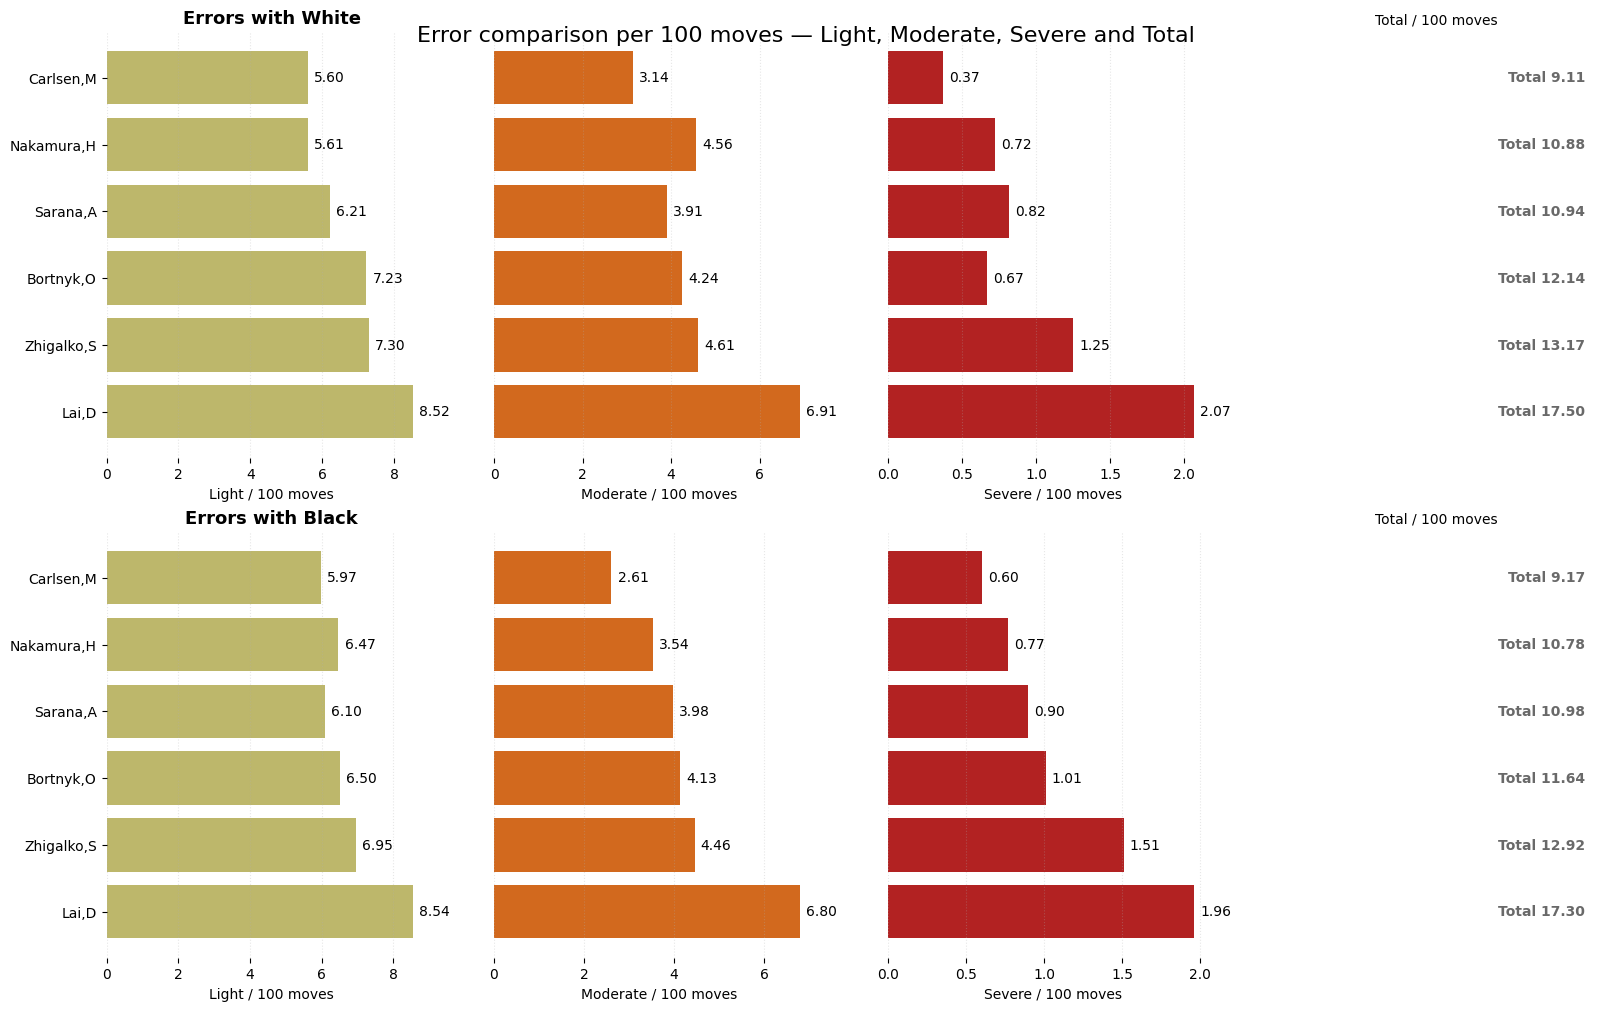

In [14]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# ======================================
# 1) Aggregation per 100 moves
# ======================================

players_target = ["Carlsen,M", "Nakamura,H", "Lai,D",
                      "Sarana,A", "Zhigalko,S", "Bortnyk,O"]


df_src = df.copy()
df_src = df_src[df_src["jugador"].isin(players_target)].copy()

# Ensure numeric columns
for c in ["errores_leves", "errores", "errores_graves", "movimientos_total"]:
    df_src[c] = pd.to_numeric(df_src.get(c, 0), errors="coerce").fillna(0).astype(int)

agg100 = (
    df_src.groupby(["jugador", "color"], as_index=False)
    .agg(
        Games=("jugador", "count"),
        Moves=("movimientos_total", "sum"),
        Light=("errores_leves", "sum"),
        Moderate=("errores", "sum"),
        Severe=("errores_graves", "sum"),
    )
)
agg100["Total"] = agg100["Light"] + agg100["Moderate"] + agg100["Severe"]

# Rates per 100 moves
for col in ["Light", "Moderate", "Severe", "Total"]:
    agg100[f"{col}/100moves"] = np.where(
        agg100["Moves"] > 0, agg100[col] / agg100["Moves"] * 100, np.nan
    ).round(2)

# ======================================
# 2) Prepare data by color
# ======================================
agg_idx = agg100.set_index(["jugador", "color"])

def prepare_100moves(df_idx, color):
    if "color" not in df_idx.index.names or color not in df_idx.index.get_level_values("color"):
        return pd.DataFrame()
    d = df_idx.xs(color, level="color").copy()
    cols = ["Light/100moves", "Moderate/100moves", "Severe/100moves", "Total/100moves"]
    d = d[cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    return d.sort_values("Total/100moves", ascending=True)

data_W = prepare_100moves(agg_idx, "W")
data_B = prepare_100moves(agg_idx, "B")

# ======================================
# 3) Plot
# ======================================
c_light, c_mod, c_sev, c_tot = "darkkhaki", "chocolate", "firebrick", "dimgray"

def label_bars(ax, y, vals, offset_ratio=0.02, fmt="{:.2f}"):
    vmax = max(0.01, float(np.nanmax(vals)))
    for i, v in enumerate(vals):
        if v > 0:
            ax.text(v + vmax * offset_ratio, i, fmt.format(v),
                    va="center", fontsize=10)

def plot_panel(fig, gs_row, data, title):
    """Compact panel with Light | Moderate | Severe | Total"""
    if data.empty:
        ax = fig.add_subplot(gs_row[0])
        ax.axis("off")
        ax.set_title(f"(No data for {title})", fontsize=13)
        return

    players = data.index.tolist()
    y = np.arange(len(players))

    xmax_vals = {
        "Light": data["Light/100moves"].max(),
        "Moderate": data["Moderate/100moves"].max(),
        "Severe": data["Severe/100moves"].max(),
    }

    # Axes
    ax_light   = fig.add_subplot(gs_row[0])
    ax_mod     = fig.add_subplot(gs_row[1], sharey=ax_light)
    ax_sev     = fig.add_subplot(gs_row[2], sharey=ax_light)
    ax_total   = fig.add_subplot(gs_row[3], sharey=ax_light)

    # --- Light errors ---
    vals_light = data["Light/100moves"].to_numpy()
    ax_light.barh(y, vals_light, color=c_light)
    ax_light.set_xlim(0, xmax_vals["Light"] * 1.08)
    ax_light.set_yticks(y)
    ax_light.set_yticklabels(players, fontsize=10)
    ax_light.invert_yaxis()
    ax_light.set_xlabel("Light / 100 moves", fontsize=10)
    ax_light.set_title(f"Errors with {title}", fontsize=13, weight="bold")
    label_bars(ax_light, y, vals_light)
    ax_light.grid(axis="x", linestyle=":", alpha=0.3)
    for sp in ax_light.spines.values():
        sp.set_visible(False)

    # --- Moderate errors ---
    vals_mod = data["Moderate/100moves"].to_numpy()
    ax_mod.barh(y, vals_mod, color=c_mod)
    ax_mod.set_xlim(0, xmax_vals["Moderate"] * 1.08)
    ax_mod.tick_params(axis='y', labelleft=False, left=False)
    ax_mod.set_xlabel("Moderate / 100 moves", fontsize=10)
    label_bars(ax_mod, y, vals_mod)
    ax_mod.grid(axis="x", linestyle=":", alpha=0.3)
    for sp in ax_mod.spines.values():
        sp.set_visible(False)

    # --- Severe errors ---
    vals_sev = data["Severe/100moves"].to_numpy()
    ax_sev.barh(y, vals_sev, color=c_sev)
    ax_sev.set_xlim(0, xmax_vals["Severe"] * 1.08)
    ax_sev.tick_params(axis='y', labelleft=False, left=False)
    ax_sev.set_xlabel("Severe / 100 moves", fontsize=10)
    label_bars(ax_sev, y, vals_sev)
    ax_sev.grid(axis="x", linestyle=":", alpha=0.3)
    for sp in ax_sev.spines.values():
        sp.set_visible(False)

    # --- Total ---
    ax_total.set_xlim(0, 1)
    ax_total.tick_params(axis='y', labelleft=False, left=False)
    ax_total.set_xticks([])
    for sp in ax_total.spines.values():
        sp.set_visible(False)
    for i, v in enumerate(data["Total/100moves"].to_numpy()):
        ax_total.text(0.95, i, f"Total {v:.2f}", va="center", ha="right",
                      fontsize=10, color=c_tot, weight="bold")
    ax_total.set_title("Total / 100 moves", fontsize=10)

# ======== Figure layout ========
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
gs = GridSpec(nrows=2, ncols=4, figure=fig, height_ratios=[1, 1], width_ratios=[4.8, 4, 4, 1.4], wspace=0.15)

plot_panel(fig, gs[0, :].subgridspec(1, 4, wspace=0.1), data_W, "White")
plot_panel(fig, gs[1, :].subgridspec(1, 4, wspace=0.1), data_B, "Black")

plt.suptitle("Error comparison per 100 moves — Light, Moderate, Severe and Total", fontsize=16, y=0.98)
plt.show()


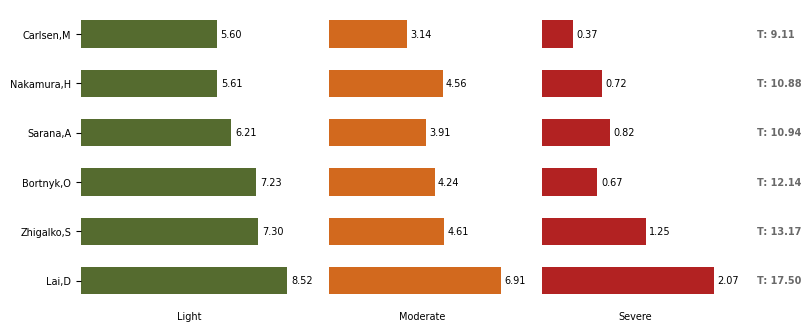

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Renombrar si no lo has hecho antes
agr100 = agr100.rename(columns={
    "Leves/100mov": "Light/100moves",
    "Moderados/100mov": "Moderate/100moves",
    "Graves/100mov": "Severe/100moves",
    "Total/100mov": "Total/100moves"
})

# --- Índice por jugador y color ---
agg_idx = agr100.set_index(["jugador", "color"])

def prepare_100moves(df_idx, color):
    if "color" not in df_idx.index.names or color not in df_idx.index.get_level_values("color"):
        return pd.DataFrame()
    d = df_idx.xs(color, level="color").copy()
    cols = ["Light/100moves", "Moderate/100moves", "Severe/100moves", "Total/100moves"]
    d = d[cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    return d.sort_values("Total/100moves", ascending=True)

data_W = prepare_100moves(agg_idx, "W")

# --- Colores y helper ---
c_light, c_mod, c_sev, c_tot = "darkolivegreen", "chocolate", "firebrick", "dimgray"

def label_bars(ax, y, vals, offset_ratio=0.02, fmt="{:.2f}"):
    vmax = max(0.01, float(np.nanmax(vals)))
    for i, v in enumerate(vals):
        if v > 0:
            ax.text(v + vmax * offset_ratio, i, fmt.format(v),
                    va="center", fontsize=7)

# === FIGURA COMPACTA ===
fig = plt.figure(figsize=(8, 3.2), constrained_layout=True)
gs = GridSpec(
    nrows=1, ncols=4, figure=fig,
    width_ratios=[3.5, 3.0, 3.0, 0.7],
    wspace=0.08
)

players = data_W.index.tolist()
y = np.arange(len(players))

xmax = {
    "Light":    data_W["Light/100moves"].max(),
    "Moderate": data_W["Moderate/100moves"].max(),
    "Severe":   data_W["Severe/100moves"].max(),
}

ax_light = fig.add_subplot(gs[0])
ax_mod   = fig.add_subplot(gs[1], sharey=ax_light)
ax_sev   = fig.add_subplot(gs[2], sharey=ax_light)
ax_total = fig.add_subplot(gs[3], sharey=ax_light)

bar_h = 0.55  # grosor barras

# --- Light ---
vals = data_W["Light/100moves"].to_numpy()
ax_light.barh(y, vals, height=bar_h, color=c_light)
ax_light.set_yticks(y)
ax_light.set_yticklabels(players, fontsize=7)
ax_light.invert_yaxis()
ax_light.set_ylim(len(players) - 0.5, -0.5)
ax_light.set_xlabel("Light", fontsize=7)
label_bars(ax_light, y, vals)
# ❌ Sin rejilla ni marcas
ax_light.grid(False)
ax_light.tick_params(axis='x', bottom=False, labelbottom=False)
for sp in ax_light.spines.values():
    sp.set_visible(False)

# --- Moderate ---
vals = data_W["Moderate/100moves"].to_numpy()
ax_mod.barh(y, vals, height=bar_h, color=c_mod)
ax_mod.set_xlim(0, xmax["Moderate"] * 1.08)
ax_mod.tick_params(axis='y', labelleft=False, left=False)
ax_mod.set_xlabel("Moderate", fontsize=7)
label_bars(ax_mod, y, vals)
ax_mod.grid(False)
ax_mod.tick_params(axis='x', bottom=False, labelbottom=False)
for sp in ax_mod.spines.values():
    sp.set_visible(False)

# --- Severe ---
vals = data_W["Severe/100moves"].to_numpy()
ax_sev.barh(y, vals, height=bar_h, color=c_sev)
ax_sev.set_xlim(0, xmax["Severe"] * 1.08)
ax_sev.tick_params(axis='y', labelleft=False, left=False)
ax_sev.set_xlabel("Severe", fontsize=7)
label_bars(ax_sev, y, vals)
ax_sev.grid(False)
ax_sev.tick_params(axis='x', bottom=False, labelbottom=False)
for sp in ax_sev.spines.values():
    sp.set_visible(False)

# --- Total (texto pegado) ---
ax_total.set_xlim(0, 1)
ax_total.set_ylim(ax_light.get_ylim())
ax_total.tick_params(axis='y', labelleft=False, left=False)
ax_total.set_xticks([])
for sp in ax_total.spines.values():
    sp.set_visible(False)

for i, v in enumerate(data_W["Total/100moves"].to_numpy()):
    ax_total.text(
        0.05, i, f"T: {v:.2f}",
        va="center", ha="left",
        fontsize=7, color=c_tot, weight="bold"
    )

# fig.suptitle("Errors with White pieces (%)", fontsize=10, weight="bold", y=1.05)

plt.savefig("errores_barras_W.png", dpi=400, bbox_inches='tight')
plt.show()


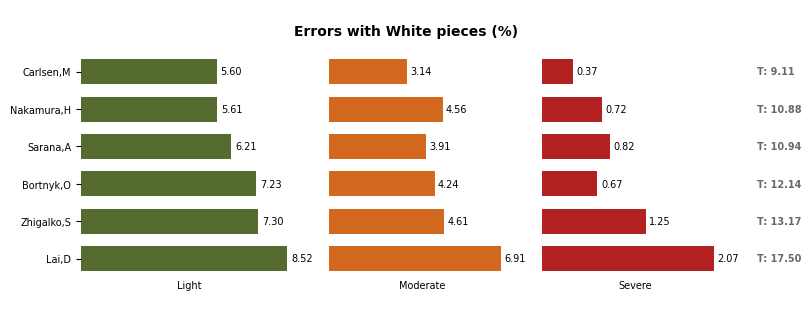

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Renombrar si no lo has hecho antes
agr100 = agr100.rename(columns={
    "Leves/100mov": "Light/100moves",
    "Moderados/100mov": "Moderate/100moves",
    "Graves/100mov": "Severe/100moves",
    "Total/100mov": "Total/100moves"
})

# --- Índice por jugador y color ---
agg_idx = agr100.set_index(["jugador", "color"])

def prepare_100moves(df_idx, color):
    if "color" not in df_idx.index.names or color not in df_idx.index.get_level_values("color"):
        return pd.DataFrame()
    d = df_idx.xs(color, level="color").copy()
    cols = ["Light/100moves", "Moderate/100moves", "Severe/100moves", "Total/100moves"]
    d = d[cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    return d.sort_values("Total/100moves", ascending=True)

# Datos para BLANCAS
data_W = prepare_100moves(agg_idx, "W")

# --- Colores y helper ---
c_light, c_mod, c_sev, c_tot = "darkolivegreen", "chocolate", "firebrick", "dimgray"

def label_bars(ax, y, vals, offset_ratio=0.02, fmt="{:.2f}"):
    vmax = max(0.01, float(np.nanmax(vals)))
    for i, v in enumerate(vals):
        if v > 0:
            ax.text(v + vmax * offset_ratio, y[i], fmt.format(v),
                    va="center", fontsize=7)

# === FIGURA COMPACTA ===
fig = plt.figure(figsize=(8, 3.2), constrained_layout=True)
gs = GridSpec(
    nrows=1, ncols=4, figure=fig,
    width_ratios=[3.5, 3.0, 3.0, 0.7],
    wspace=0.08
)

players = data_W.index.tolist()

# --- Posiciones Y compactas ---
spacing = 0.3
y = np.arange(len(players)) * spacing

xmax = {
    "Light":    data_W["Light/100moves"].max(),
    "Moderate": data_W["Moderate/100moves"].max(),
    "Severe":   data_W["Severe/100moves"].max(),
}

ax_light = fig.add_subplot(gs[0])
ax_mod   = fig.add_subplot(gs[1], sharey=ax_light)
ax_sev   = fig.add_subplot(gs[2], sharey=ax_light)
ax_total = fig.add_subplot(gs[3], sharey=ax_light)

bar_h = 0.2

# --- Light ---
vals = data_W["Light/100moves"].to_numpy()
ax_light.barh(y, vals, height=bar_h, color=c_light)
ax_light.set_yticks(y)
ax_light.set_yticklabels(players, fontsize=7)
ax_light.invert_yaxis()
ax_light.set_ylim(y.max() + 0.5, y.min() - 0.5)

ax_light.set_xlabel("Light", fontsize=7)
ax_light.xaxis.set_label_coords(0.5, 0.13)   # ⭐ Subimos la etiqueta
label_bars(ax_light, y, vals)

ax_light.grid(False)
ax_light.tick_params(axis='x', bottom=False, labelbottom=False)
for sp in ax_light.spines.values():
    sp.set_visible(False)

# --- Moderate ---
vals = data_W["Moderate/100moves"].to_numpy()
ax_mod.barh(y, vals, height=bar_h, color=c_mod)
ax_mod.set_xlim(0, xmax["Moderate"] * 1.08)
ax_mod.tick_params(axis='y', labelleft=False, left=False)

ax_mod.set_xlabel("Moderate", fontsize=7)
ax_mod.xaxis.set_label_coords(0.5, 0.13)   # ⭐ Subimos la etiqueta
label_bars(ax_mod, y, vals)

ax_mod.grid(False)
ax_mod.tick_params(axis='x', bottom=False, labelbottom=False)
for sp in ax_mod.spines.values():
    sp.set_visible(False)

# --- Severe ---
vals = data_W["Severe/100moves"].to_numpy()
ax_sev.barh(y, vals, height=bar_h, color=c_sev)
ax_sev.set_xlim(0, xmax["Severe"] * 1.08)
ax_sev.tick_params(axis='y', labelleft=False, left=False)

ax_sev.set_xlabel("Severe", fontsize=7)
ax_sev.xaxis.set_label_coords(0.5, 0.13)   # ⭐ Subimos la etiqueta
label_bars(ax_sev, y, vals)

ax_sev.grid(False)
ax_sev.tick_params(axis='x', bottom=False, labelbottom=False)
for sp in ax_sev.spines.values():
    sp.set_visible(False)

# --- Sincronizar límites Y ---
ylim = ax_light.get_ylim()
ax_mod.set_ylim(ylim)
ax_sev.set_ylim(ylim)
ax_total.set_ylim(ylim)

# --- Total ---
ax_total.set_xlim(0, 1)
ax_total.tick_params(axis='y', labelleft=False, left=False)
ax_total.set_xticks([])
for sp in ax_total.spines.values():
    sp.set_visible(False)

for i, v in enumerate(data_W["Total/100moves"].to_numpy()):
    ax_total.text(
        0.05, y[i], f"T: {v:.2f}",
        va="center", ha="left",
        fontsize=7, color=c_tot, weight="bold"
    )

fig.suptitle("Errors with White pieces (%)", fontsize=10, weight="bold", y=0.94)
plt.savefig("errores_barras_W_compacto.png", dpi=400, bbox_inches='tight')
plt.show()


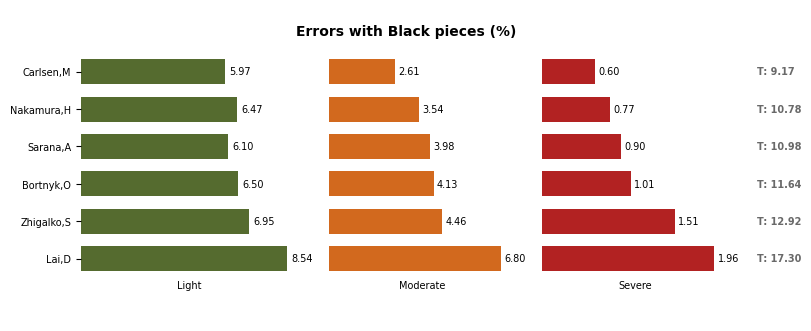

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Renombrar columnas si no se ha hecho antes
agr100 = agr100.rename(columns={
    "Leves/100mov": "Light/100moves",
    "Moderados/100mov": "Moderate/100moves",
    "Graves/100mov": "Severe/100moves",
    "Total/100mov": "Total/100moves"
})

# --- Índice por jugador y color ---
agg_idx = agr100.set_index(["jugador", "color"])

def prepare_100moves(df_idx, color):
    if "color" not in df_idx.index.names or color not in df_idx.index.get_level_values("color"):
        return pd.DataFrame()
    d = df_idx.xs(color, level="color").copy()
    cols = ["Light/100moves", "Moderate/100moves", "Severe/100moves", "Total/100moves"]
    d = d[cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    return d.sort_values("Total/100moves", ascending=True)

# Datos para NEGRAS
data_B = prepare_100moves(agg_idx, "B")

# --- Colores y helper ---
c_light, c_mod, c_sev, c_tot = "darkolivegreen", "chocolate", "firebrick", "dimgray"

def label_bars(ax, y, vals, offset_ratio=0.02, fmt="{:.2f}"):
    vmax = max(0.01, float(np.nanmax(vals)))
    for yi, v in zip(y, vals):
        if v > 0:
            ax.text(v + vmax * offset_ratio, yi, fmt.format(v),
                    va="center", fontsize=7)

# === FIGURA COMPACTA PARA NEGRAS ===
fig = plt.figure(figsize=(8, 3.2), constrained_layout=True)
gs = GridSpec(
    nrows=1, ncols=4, figure=fig,
    width_ratios=[3.5, 3.0, 3.0, 0.7],
    wspace=0.08
)

players = data_B.index.tolist()

# Posiciones Y compactas (igual que en blancas)
spacing = 0.3
y = np.arange(len(players)) * spacing

xmax = {
    "Light":    data_B["Light/100moves"].max(),
    "Moderate": data_B["Moderate/100moves"].max(),
    "Severe":   data_B["Severe/100moves"].max(),
}

ax_light = fig.add_subplot(gs[0])
ax_mod   = fig.add_subplot(gs[1], sharey=ax_light)
ax_sev   = fig.add_subplot(gs[2], sharey=ax_light)
ax_total = fig.add_subplot(gs[3], sharey=ax_light)

bar_h = 0.2  # barras finas

# --- Light ---
vals = data_B["Light/100moves"].to_numpy()
ax_light.barh(y, vals, height=bar_h, color=c_light)
ax_light.set_yticks(y)
ax_light.set_yticklabels(players, fontsize=7)
ax_light.invert_yaxis()
ax_light.set_ylim(y.max() + 0.5, y.min() - 0.5)

ax_light.set_xlabel("Light", fontsize=7)
ax_light.xaxis.set_label_coords(0.5, 0.13)   # etiqueta más cerca de las barras
label_bars(ax_light, y, vals)

ax_light.grid(False)
ax_light.tick_params(axis='x', bottom=False, labelbottom=False)
for sp in ax_light.spines.values():
    sp.set_visible(False)

# --- Moderate ---
vals = data_B["Moderate/100moves"].to_numpy()
ax_mod.barh(y, vals, height=bar_h, color=c_mod)
ax_mod.set_xlim(0, xmax["Moderate"] * 1.08)
ax_mod.tick_params(axis='y', labelleft=False, left=False)

ax_mod.set_xlabel("Moderate", fontsize=7)
ax_mod.xaxis.set_label_coords(0.5, 0.13)
label_bars(ax_mod, y, vals)

ax_mod.grid(False)
ax_mod.tick_params(axis='x', bottom=False, labelbottom=False)
for sp in ax_mod.spines.values():
    sp.set_visible(False)

# --- Severe ---
vals = data_B["Severe/100moves"].to_numpy()
ax_sev.barh(y, vals, height=bar_h, color=c_sev)
ax_sev.set_xlim(0, xmax["Severe"] * 1.08)
ax_sev.tick_params(axis='y', labelleft=False, left=False)

ax_sev.set_xlabel("Severe", fontsize=7)
ax_sev.xaxis.set_label_coords(0.5, 0.13)
label_bars(ax_sev, y, vals)

ax_sev.grid(False)
ax_sev.tick_params(axis='x', bottom=False, labelbottom=False)
for sp in ax_sev.spines.values():
    sp.set_visible(False)

# --- Sincronizar límites Y ---
ylim = ax_light.get_ylim()
ax_mod.set_ylim(ylim)
ax_sev.set_ylim(ylim)
ax_total.set_ylim(ylim)

# --- Total (texto) ---
ax_total.set_xlim(0, 1)
ax_total.tick_params(axis='y', labelleft=False, left=False)
ax_total.set_xticks([])
for sp in ax_total.spines.values():
    sp.set_visible(False)

for yi, v in zip(y, data_B["Total/100moves"].to_numpy()):
    ax_total.text(
        0.05, yi, f"T: {v:.2f}",
        va="center", ha="left",
        fontsize=7, color=c_tot, weight="bold"
    )

fig.suptitle("Errors with Black pieces (%)", fontsize=10, weight="bold", y=0.94)
plt.savefig("errores_barras_B_compacto.png", dpi=400, bbox_inches='tight')
plt.show()


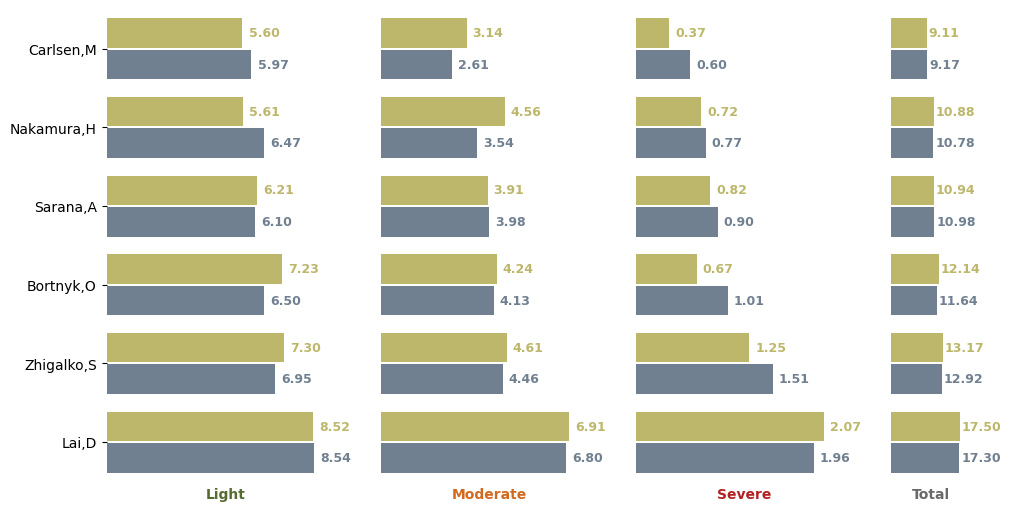

In [18]:
# ======================================================
# 1. Renombrar columnas base (si no está hecho ya)
# ======================================================
agr100 = agr100.rename(columns={
    "Leves/100mov": "Light/100moves",
    "Moderados/100mov": "Moderate/100moves",
    "Graves/100mov": "Severe/100moves",
    "Total/100mov": "Total/100moves"
})

# ======================================================
# 2. Preparar datos por color
# ======================================================
agg_idx = agr100.set_index(["jugador", "color"])

def prepare_100moves(df_idx, color):
    if "color" not in df_idx.index.names:
        return pd.DataFrame()
    if color not in df_idx.index.get_level_values("color"):
        return pd.DataFrame()
    d = df_idx.xs(color, level="color").copy()
    cols = ["Light/100moves", "Moderate/100moves", "Severe/100moves", "Total/100moves"]
    d = d[cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    return d

data_W = prepare_100moves(agg_idx, "W").rename(columns=lambda c: c.replace("/100moves", "_W"))
data_B = prepare_100moves(agg_idx, "B").rename(columns=lambda c: c.replace("/100moves", "_B"))

# Combinar por jugador
df_comb = data_W.join(data_B, how="outer")

# Asegurar columnas numéricas
for col in ["Light", "Moderate", "Severe", "Total"]:
    for side in ["W", "B"]:
        cname = f"{col}_{side}"
        if cname not in df_comb.columns:
            df_comb[cname] = 0.0
        df_comb[cname] = pd.to_numeric(df_comb[cname], errors="coerce").fillna(0.0)

# Filtrar jugadores con datos
df_plot = df_comb[df_comb.sum(axis=1) > 0].copy()

# ------------------------------------------------------
# ORDENAR POR TOTAL DE ERRORES COMBINADO (W + B)
# ------------------------------------------------------
df_plot["Total_combined"] = df_plot["Total_W"] + df_plot["Total_B"]
df_plot = df_plot.sort_values("Total_combined", ascending=True)

players = df_plot.index.to_list()
n = len(players)

# ======================================================
# 3. Parámetros visuales
# ======================================================
color_map = {"W": "darkkhaki", "B": "slategray"}

bar_h = 1.5
offset = 0.8
gap = 4
y_base = np.arange(n) * gap

cols = ["Light", "Moderate", "Severe", "Total"]

# Colores para las etiquetas de eje x
label_colors = {
    "Light": "darkolivegreen",
    "Moderate": "chocolate",
    "Severe": "firebrick",
    "Total": "dimgray",
}

# ======================================================
# 4. Figura y función de pintado
# ======================================================
fig = plt.figure(figsize=(10, 5), constrained_layout=True)
gs = GridSpec(1, 4, figure=fig, width_ratios=[3.3, 3.0, 3.0, 1.1], wspace=0.12)

axes = [fig.add_subplot(gs[i]) for i in range(4)]

def plot_dual_bars(ax, col, df, players, y_base, bar_h, offset):
    W_vals = df[f"{col}_W"].to_numpy()
    B_vals = df[f"{col}_B"].to_numpy()

    m = min(len(players), len(y_base), len(W_vals), len(B_vals))
    players_m = players[:m]
    y = y_base[:m]
    W_vals = W_vals[:m]
    B_vals = B_vals[:m]

    max_val = max(W_vals.max(initial=0), B_vals.max(initial=0))
    ax.set_xlim(0, max_val * 1.15 if max_val > 0 else 1.0)

    ax.barh(y - offset, W_vals, height=bar_h, color=color_map["W"])
    ax.barh(y + offset, B_vals, height=bar_h, color=color_map["B"])

    ax.set_yticks(y)
    if col == "Light":
        ax.set_yticklabels(players_m, fontsize=10)
    else:
        ax.set_yticklabels([])
        ax.tick_params(axis="y", left=False)

    ax.grid(False)
    ax.tick_params(axis='x', bottom=False, labelbottom=False)

    for sp in ax.spines.values():
        sp.set_visible(False)

    ax.set_xlabel(
        col,
        fontsize=10,
        fontweight="bold",
        color=label_colors.get(col, "black")
    )

    x_max = ax.get_xlim()[1]
    for i in range(m):
        if W_vals[i] > 0:
            tx = min(W_vals[i] + max_val * 0.03, x_max * 0.97)
            ax.text(
                tx, y[i] - offset, f"{W_vals[i]:.2f}",
                va="center", ha="left",
                fontsize=9,
                color=color_map["W"],
                fontweight="bold"
            )
        if B_vals[i] > 0:
            tx = min(B_vals[i] + max_val * 0.03, x_max * 0.97)
            ax.text(
                tx, y[i] + offset, f"{B_vals[i]:.2f}",
                va="center", ha="left",
                fontsize=9,
                color=color_map["B"],
                fontweight="bold"
            )

    ymin = y[0] - (gap * 0.5)
    ymax = y[-1] + (gap * 0.5)
    ax.set_ylim(ymax, ymin)

# Pintar columnas
for ax, col in zip(axes, cols):
    plot_dual_bars(ax, col, df_plot, players, y_base, bar_h, offset)

plt.savefig("errores_barra_conjunto.png", dpi=400, bbox_inches='tight')
plt.show()


#### Análisis gráfico de los errores por fase. Gráficos de radar.

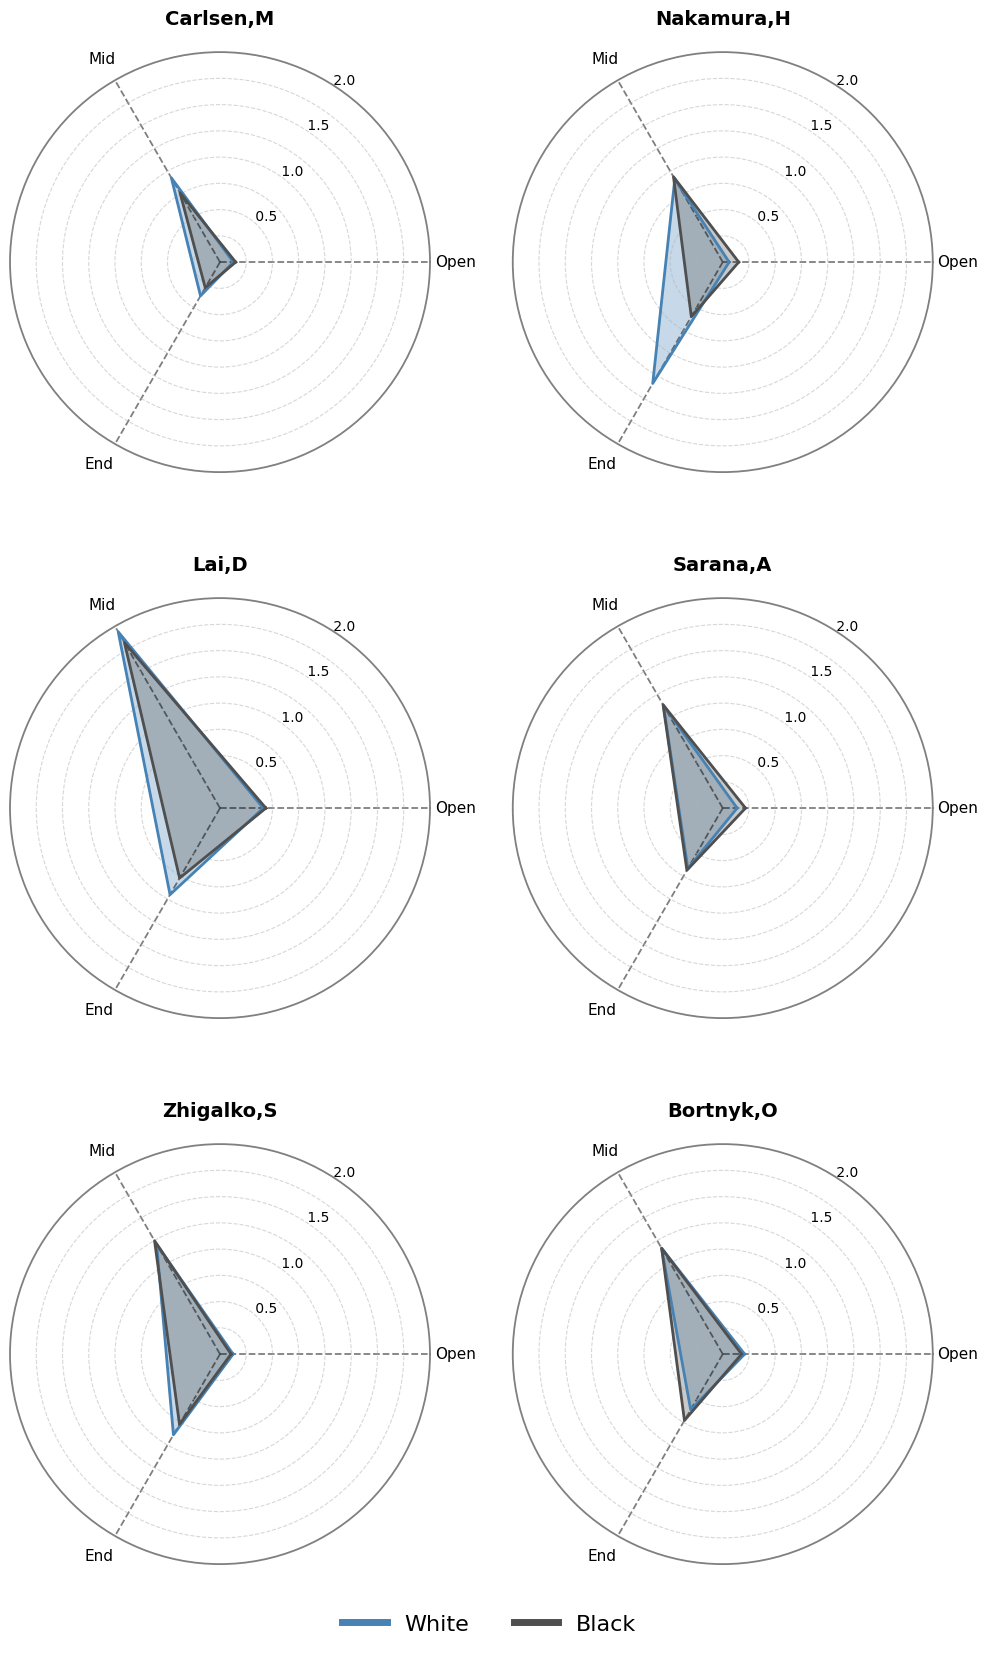

In [19]:
# -------------------------------------------------------
# df debe tener columnas:
# ['jugador','color','errores_apertura','errores_mediojuego','errores_final']
# -------------------------------------------------------

# 1) Select target players
target_players = ["Carlsen,M", "Nakamura,H", "Lai,D",
                  "Sarana,A", "Zhigalko,S", "Bortnyk,O"]

# 2) Filter and aggregate by player and color (using your Spanish column names)
required_cols = ["jugador", "color",
                 "errores_apertura", "errores_mediojuego", "errores_final"]

df_radar_pd = (
    df.loc[df["jugador"].isin(target_players), required_cols]
      .assign(partidas=1)  # for counting games
      .groupby(["jugador", "color"], as_index=True)
      .agg(
          partidas=("partidas", "sum"),
          errores_apertura=("errores_apertura", "sum"),
          errores_mediojuego=("errores_mediojuego", "sum"),
          errores_final=("errores_final", "sum"),
      )
)

# 3) Compute errors per game
phases = ["apertura", "mediojuego", "final"]
for phase in phases:
    df_radar_pd[f"{phase}/p"] = df_radar_pd[f"errores_{phase}"] / df_radar_pd["partidas"]

# 4) Radar chart configuration (labels in English)
labels = ["Open", "Mid", "End"]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # close polygon
colors = {"W": "#4682b4", "B": "#4f4f4f"}  # White, Black

# 4b) Global radial scale
if not df_radar_pd.empty:
    global_max = df_radar_pd[[f"{p}/p" for p in phases]].to_numpy().max()
else:
    global_max = 0.0

base_rmax = max(global_max, 0.1)
radial_max = np.ceil((base_rmax + 0.05) * 2) / 2.0
yticks = np.arange(0.25, radial_max + 0.001, 0.25)

# Angle tweaks for phase labels
angle_adjust = {"Open": 0, "Mid": 0, "End":-1}
label_factor = 1.12
label_radii = {lab: radial_max * label_factor for lab in labels}
label_radii["Opening"] = radial_max * 1.2   # push it slightly outward
label_radii["Middlegame"] = radial_max * 1.18   # push it slightly outward

# 5) Figure: 3x2 grid
fig, axs = plt.subplots(
    3, 2, figsize=(18, 18),
    subplot_kw=dict(polar=True)
)

fig.subplots_adjust(
    left=0.04, right=0.94, top=0.96, bottom=0.12,
    wspace=-0.55,
    hspace=0.3
)

axs = axs.flatten()

# 6) One radar per player
for idx, player in enumerate(target_players):
    if idx >= len(axs):
        break
    ax = axs[idx]
    values = {}

    for color in ["W", "B"]:
        if (player, color) in df_radar_pd.index:
            row = df_radar_pd.loc[(player, color)]
            vals = [row[f"{phase}/p"] for phase in phases]
        else:
            vals = [0.0, 0.0, 0.0]
        vals.append(vals[0])  # close polygon
        values[color] = vals

    # Polygons and fills
    ax.plot(angles, values["W"], label="White",
            color=colors["W"], linewidth=2)
    ax.fill(angles, values["W"], color=colors["W"], alpha=0.3)

    ax.plot(angles, values["B"], label="Black",
            color=colors["B"], linewidth=2)
    ax.fill(angles, values["B"], color=colors["B"], alpha=0.3)

    # Radial scale
    ax.set_ylim(0, radial_max)
    ax.set_yticks(yticks)
    ax.set_yticklabels([""] * len(yticks))

    # Numeric rings
    for r in np.arange(0.5, radial_max + 0.001, 0.5):
        ax.text(np.pi / 3, r, f"         {r:.1f}",
                ha="center", va="center", fontsize=10, color="black")

    # Angular grid
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])
    ax.xaxis.grid(True, linestyle="--", color="black", linewidth=1.3)

    # Polar border
    ax.spines["polar"].set_visible(True)
    ax.spines["polar"].set_color("gray")
    ax.spines["polar"].set_linewidth(1.3)

    # Phase labels (in English) around the circle
    for i, lab in enumerate(labels):
        x_deg = np.degrees(angles[i]) + angle_adjust[lab]
        r_lab = label_radii[lab]
        ax.text(np.radians(x_deg), r_lab, lab,
                ha="center", va="center", fontsize=11)

    ax.set_title(player, fontsize=14, fontweight="bold", pad=20)
    ax.grid(True, linestyle="--", alpha=0.5)

# 7) Remove empty axes
for j in range(len(target_players), len(axs)):
    fig.delaxes(axs[j])

# 8) Global legend
legend_elements = [
    Line2D([0], [0], color=colors["W"], lw=5, label="White"),
    Line2D([0], [0], color=colors["B"], lw=5, label="Black")
]
fig.legend(
    handles=legend_elements, loc="lower center", ncol=2,
    fontsize=16, frameon=False, bbox_to_anchor=(0.5, 0.07)
)

# Optional global title
#fig.suptitle("Average errors per game by phase — White vs Black",
#             fontsize=18, fontweight="bold", y=0.99)

plt.savefig("radar_errors.png", dpi=400, bbox_inches='tight')
plt.show()


## 2.5 Estudio de las aperturas

In [20]:
# ------------------------------------------------------------
# Configuración
# ------------------------------------------------------------
jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Lai,D",
                      "Sarana,A", "Zhigalko,S", "Bortnyk,O"]

# ------------------------------------------------------------
# 1) Extraer ECO y Opening desde el PGN
# ------------------------------------------------------------
eco_pat = re.compile(r'\[ECO "(.*?)"\]')
opening_pat = re.compile(r'\[Opening "(.*?)"\]')

def extraer_opening_eco(pgn):
    eco = opening = None
    if isinstance(pgn, str):
        m1 = eco_pat.search(pgn)
        m2 = opening_pat.search(pgn)
        if m1: eco = m1.group(1)
        if m2: opening = m2.group(1)
    return pd.Series({"cod_eco": eco, "opening": opening})

df = df.copy()
df[["cod_eco", "opening"]] = df["pgn"].apply(extraer_opening_eco)

# ------------------------------------------------------------
# 2) Filtrar jugadores objetivo
# ------------------------------------------------------------
df_filtrado = df[df["jugador"].isin(jugadores_objetivo)].copy()

df_filtrado["movimientos_total"] = pd.to_numeric(
    df_filtrado.get("movimientos_total", 0),
    errors="coerce"
).fillna(0).astype(int)

# ------------------------------------------------------------
# 3) Agregar SOLO por nombre de apertura  (NO por ECO)
# ------------------------------------------------------------
agrupado_pd = (
    df_filtrado
      .groupby(["jugador", "color", "opening"], as_index=False)
      .agg(
          partidas=("jugador", "count"),
          movimientos_total=("movimientos_total", "sum"),
          errores_leves=("errores_leves_apertura", "sum"),
          errores_moderados=("errores_apertura", "sum"),
          errores_graves=("errores_graves_apertura", "sum"),
          eval_prom=("eval_apertura", "mean"),
          # ECO: nos quedamos con EL PRIMERO encontrado (sin agrupar por ECO)
          cod_eco=("cod_eco", "first")
      )
)

# ------------------------------------------------------------
# 4) Generar tablas por jugador (W / B)
# ------------------------------------------------------------
def generar_tablas_por_jugador(df_in, jugador):
    df_jugador = df_in[df_in["jugador"] == jugador].copy()
    resultado = {}

    for color in ["W", "B"]:
        df_color = df_jugador[df_jugador["color"] == color].copy()
        if df_color.empty:
            resultado[color] = pd.DataFrame()
            continue

        total_partidas = df_color["partidas"].sum()

        df_color["uso (%)"] = np.where(
            total_partidas > 0,
            100 * df_color["partidas"] / total_partidas,
            0.0
        )

        # Errores por 100 movimientos
        df_color["errores_leves_100"] = np.where(
            df_color["movimientos_total"] > 0,
            100 * df_color["errores_leves"] / df_color["movimientos_total"],
            np.nan
        )
        df_color["errores_moderados_100"] = np.where(
            df_color["movimientos_total"] > 0,
            100 * df_color["errores_moderados"] / df_color["movimientos_total"],
            np.nan
        )
        df_color["errores_graves_100"] = np.where(
            df_color["movimientos_total"] > 0,
            100 * df_color["errores_graves"] / df_color["movimientos_total"],
            np.nan
        )

        df_color = df_color.rename(columns={"opening": "apertura"})

        columnas = [
            "cod_eco",                 # ← YA NO se usa como clave del groupby
            "apertura",
            "uso (%)",
            "eval_prom",
            "errores_leves_100",
            "errores_moderados_100",
            "errores_graves_100"
        ]

        tabla = (
            df_color[columnas]
            .round({
                "uso (%)": 2,
                "eval_prom": 2,
                "errores_leves_100": 2,
                "errores_moderados_100": 2,
                "errores_graves_100": 2,
            })
            .sort_values("uso (%)", ascending=False)
            .reset_index(drop=True)
        )

        resultado[color] = tabla

    return resultado

# ------------------------------------------------------------
# 5) Resultado final
# ------------------------------------------------------------
tablas_por_jugador = {
    jugador: generar_tablas_por_jugador(agrupado_pd, jugador)
    for jugador in jugadores_objetivo
}


In [21]:
#tablas_por_jugador["Firouzja,Alireza"]["W"].head(5)
tablas_por_jugador["Lai,D"]["W"].head(5)


,cod_eco,apertura,uso (%),eval_prom,errores_leves_100,errores_moderados_100,errores_graves_100
0,A45,Queen's pawn game,15.76,0.28,2.15,1.19,0.18
1,B23,Sicilian,11.58,0.27,1.31,0.84,0.10
2,A10,English opening,7.72,0.11,1.76,0.77,0.00
3,D37,QGD,7.40,0.25,0.96,0.56,0.00
4,A11,English,5.79,0.52,2.87,0.72,0.14


#### Aperturas más usadas (mapa de calor)

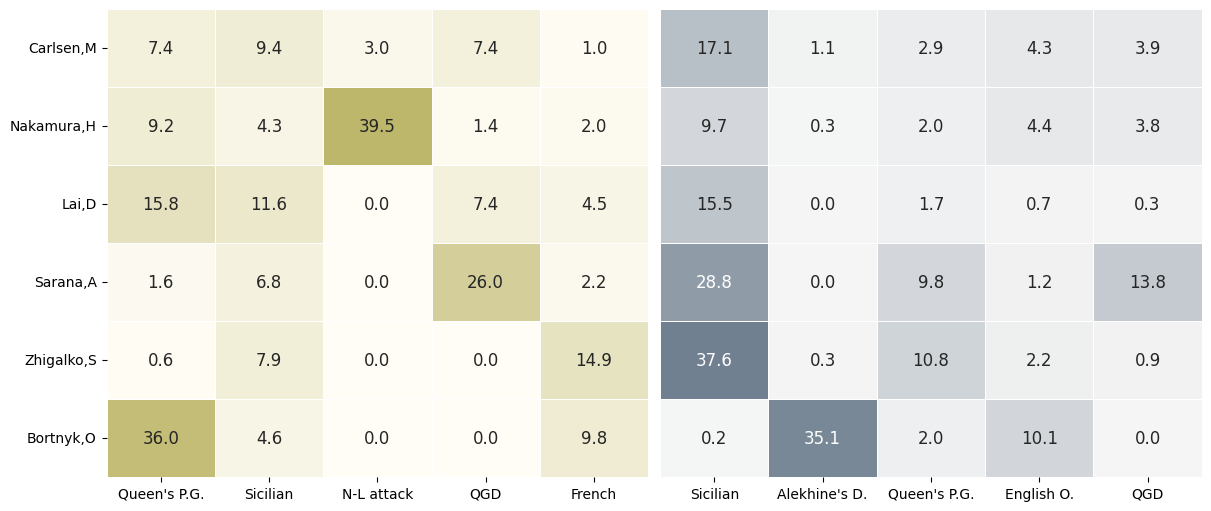

In [22]:
# =====================================================================
# ENTRADA:
#   - tablas_por_jugador: dict {jugador: {"W": DataFrame, "B": DataFrame}}
#   - Cada DataFrame tiene columnas:
#       ["cod_eco","apertura","uso (%)","eval_cp_prom",
#        "errores_leves","errores_moderados","errores_graves"]
#   - jugadores_objetivo: lista de jugadores
# =====================================================================

jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Lai,D", "Sarana,A",
                      "Zhigalko,S", "Bortnyk,O"]

# 1) Unificar tablas en un solo DataFrame
df_todo = []
for jugador, datos in tablas_por_jugador.items():
    for color in ["W", "B"]:
        tabla = datos.get(color, pd.DataFrame())
        if tabla is None or tabla.empty:
            continue
        t = tabla.copy()
        t["jugador"] = jugador
        t["color"] = "Blancas" if color == "W" else "Negras"
        df_todo.append(t)

if not df_todo:
    raise ValueError("No hay datos para construir los heatmaps (df_todo está vacío).")

df_aperturas = pd.concat(df_todo, ignore_index=True)

# Asegurar tipos
df_aperturas["uso (%)"] = pd.to_numeric(df_aperturas["uso (%)"], errors="coerce").fillna(0.0)
df_aperturas["apertura"] = df_aperturas["apertura"].astype(str)
df_aperturas["jugador"] = df_aperturas["jugador"].astype(str)

# 2) Separar por color
df_blancas = df_aperturas[df_aperturas["color"] == "Blancas"].copy()
df_negras  = df_aperturas[df_aperturas["color"] == "Negras"].copy()

# 3) Top 5 aperturas por color (sumando % de uso sobre todos los jugadores)
top_blancas = (
    df_blancas.groupby("apertura", as_index=True)["uso (%)"]
    .sum().sort_values(ascending=False).head(5).index.tolist()
)
top_negras = (
    df_negras.groupby("apertura", as_index=True)["uso (%)"]
    .sum().sort_values(ascending=False).head(5).index.tolist()
)

# 4) Pivot para heatmaps forzando tus jugadores objetivo
df_blancas_filtrado = df_blancas[df_blancas["apertura"].isin(top_blancas)].copy()
df_negras_filtrado  = df_negras[df_negras["apertura"].isin(top_negras)].copy()

pivot_blancas = (
    df_blancas_filtrado
    .pivot_table(index="jugador", columns="apertura", values="uso (%)",
                 aggfunc="sum", fill_value=0.0)
    .reindex(index=jugadores_objetivo)      # fuerza orden de jugadores
    .reindex(columns=top_blancas)           # orden de columnas según top
    .fillna(0.0)
)

pivot_negras = (
    df_negras_filtrado
    .pivot_table(index="jugador", columns="apertura", values="uso (%)",
                 aggfunc="sum", fill_value=0.0)
    .reindex(index=jugadores_objetivo)
    .reindex(columns=top_negras)
    .fillna(0.0)
)

def abreviar_apertura(nombre):

    # Caso especial exacto
    if "Nimzo" in nombre or "Nimzowitsch" in nombre or "Nimzovich" in nombre:
        return "N-L attack"

    partes = nombre.split()

    # Si solo tiene 1 palabra → no se abrevia
    if len(partes) == 1:
        return nombre

    # Primera palabra normal
    primera = partes[0]

    # Iniciales del resto ("pawn game" → "P.G.")
    iniciales = [p[0].upper() + "." for p in partes[1:]]

    return primera + " " + "".join(iniciales)


# Aplicar abreviación a las columnas del pivot
pivot_blancas.columns = [abreviar_apertura(col) for col in pivot_blancas.columns]
pivot_negras.columns  = [abreviar_apertura(col) for col in pivot_negras.columns]

# 5) Colormaps coherentes con el documento
cmap_W = LinearSegmentedColormap.from_list(
    "white_darkkhaki", ["#fffdf5", "darkkhaki"]
)
cmap_B = LinearSegmentedColormap.from_list(
    "white_slategray", ["#f5f5f5", "slategray"]
)

# 6) Graficar heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# --- Heatmap BLANCAS ---
sns.heatmap(
    pivot_blancas,
    annot=True,
    fmt=".1f",
    cmap=cmap_W,
    ax=axes[0],
    cbar=False,
    linewidths=0.5,
    linecolor="white",
    annot_kws={"size": 12}  # ← tamaño y estilo de las cifras
)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].tick_params(axis="x", rotation=0)

# --- Heatmap NEGRAS ---
sns.heatmap(
    pivot_negras,
    annot=True,
    fmt=".1f",
    cmap=cmap_B,
    ax=axes[1],
    cbar=False,
    linewidths=0.5,
    linecolor="white",
    annot_kws={"size": 12}  # ← igual aquí
)
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Quitar nombres de jugadores en el mapa de NEGRAS
axes[1].set_yticklabels([])
axes[1].tick_params(axis="y", left=False)
axes[1].tick_params(axis="x", rotation=0)

plt.savefig("aperturas.png", dpi=400, bbox_inches="tight")
plt.show()


## 6. Movimientos más habituales por pieza 

Mapa de calor de las piezas (según jugador, color y pieza) 

In [23]:
# jugadores_objetivo = ["Carlsen,M", "Nakamura,H", "Sarana,A", "Bortnyk,O", "Zhigalko,S", "Lai,D"]

jugador_objetivo = "Lai,D"
color_objetivo = "W"      # "W" para blancas, "B" para negras
pieza_objetivo = "N"      # 'P', 'N', 'B', 'R', 'Q', 'K'

nombre_piezas = {
    "P": "Peón", "N": "Caballo", "B": "Alfil",
    "R": "Torre", "Q": "Dama", "K": "Rey"
}
nombre_pieza = nombre_piezas.get(pieza_objetivo, pieza_objetivo)

# Filtro en pandas (no usar col())
df_san_pd = (
    df[(df["jugador"] == jugador_objetivo) & (df["color"] == color_objetivo)]
    .loc[:, ["san"]]
    .dropna()
)

# Si 'san' contiene listas (como suele pasar en tu DataFrame), puedes expandirlas:
df_san_exp = df_san_pd["san"].explode().reset_index(drop=True)

#print(f"Movimientos con {nombre_pieza} ({pieza_objetivo}) de {jugador_objetivo} ({color_objetivo}):")
#print(df_san_exp.head(20))  # muestra las primeras jugadas


In [24]:
# Crear tablero vacío
tablero = np.zeros((8, 8))

# Función para extraer jugadas SAN
def extraer_jugadas(san):
    if isinstance(san, str):
        san_str = san.strip("[]").replace("'", "").replace("\n", " ")
        return san_str.split()
    elif isinstance(san, (list, np.ndarray)):
        return list(san)
    else:
        return []

# Procesar jugadas y registrar posiciones destino
for san_raw in df_san_pd["san"]:
    jugadas = extraer_jugadas(san_raw)
    for jugada in jugadas:
        jugada = jugada.replace("+", "").replace("#", "").replace("x", "").replace("=", "")
        
        if pieza_objetivo == "P":
            if re.fullmatch(r"[a-h][1-8]", jugada):
                col = ord(jugada[0]) - ord('a')
                row = 8 - int(jugada[1])
                tablero[row][col] += 1
        else:
            if jugada.startswith(pieza_objetivo) and len(jugada) >= 3:
                destino = jugada[-2:]
                if destino[0] in "abcdefgh" and destino[1] in "12345678":
                    col = ord(destino[0]) - ord('a')
                    row = 8 - int(destino[1])
                    tablero[row][col] += 1


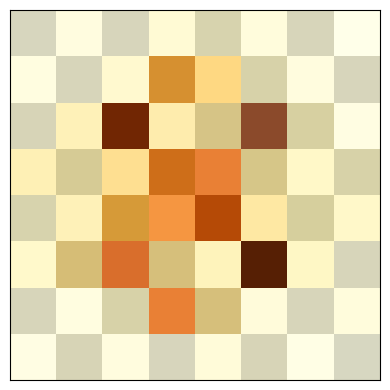

In [25]:
patron_tablero = np.add.outer(range(8), range(8)) % 2

fig, ax = plt.subplots(figsize=(4, 4))

# Fondo ajedrezado (blancas abajo)
ax.imshow(
    patron_tablero,
    cmap='binary',
    interpolation='none',
    extent=[0, 8, 0, 8],
    origin="lower",
    zorder=1
)

# Mapa de calor superpuesto (mismas coordenadas que en el multipanel)
ax.imshow(
    tablero,
    cmap="YlOrBr",
    interpolation="nearest",
    extent=[0, 8, 0, 8],
    origin="lower",
    alpha=0.85,
    zorder=2
)

#ax.set_title(f"Mapa de calor del {nombre_pieza} ({color_objetivo}) - {jugador_objetivo}", fontsize=16)

ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

plt.savefig("heatmap_knight_move.png", dpi=400, bbox_inches="tight")
plt.tight_layout()
plt.show()


#### Ubicación de la pieza

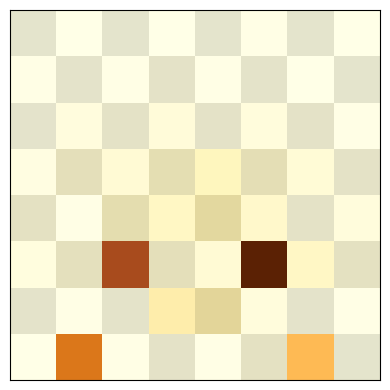

In [26]:
# Por ocupación de la casilla
# ============================================================
# 1. Helper: convertir la columna 'san' en lista de jugadas SAN
# ============================================================

def extraer_lista_san(valor):
    """
    Convierte el contenido de la columna 'san' en una lista de jugadas SAN.
    Soporta:
      - listas reales / np.array
      - cadenas tipo "['e4', 'e5', 'Cf3', ...]"
      - cadenas separadas por comas o espacios
    """
    if isinstance(valor, (list, np.ndarray)):
        return [str(x).strip() for x in valor]

    if isinstance(valor, str):
        dentro = valor.strip()

        # Quitar corchetes exteriores si los hay
        if dentro.startswith("[") and dentro.endswith("]"):
            dentro = dentro[1:-1]

        partes = [p.strip().strip("'").strip('"') for p in dentro.split(",")]
        jugadas = []
        for p in partes:
            if not p:
                continue
            jugadas.extend(p.split())  # por si además vienen separadas por espacios

        return [j for j in jugadas if j]

    # Si no se reconoce el formato, devolver lista vacía
    return []


# ============================================================
# 2. Construir tablero de OCUPACIÓN para una pieza concreta
# ============================================================

def tablero_ocupacion(df, jugador_objetivo, color_objetivo="W", pieza_objetivo="K"):
    """
    Devuelve una matriz 8x8 con el número de jugadas en las que
    la pieza indicada (tipo y color) está ocupando cada casilla.

    df               : DataFrame con columnas 'jugador', 'color', 'san'
    jugador_objetivo : nombre tal como aparece en df["jugador"]
    color_objetivo   : 'W' (blancas) o 'B' (negras)
    pieza_objetivo   : 'P','N','B','R','Q','K'
    """
    color_chess = chess.WHITE if color_objetivo == "W" else chess.BLACK

    tipo_pieza_map = {
        "P": chess.PAWN,
        "N": chess.KNIGHT,
        "B": chess.BISHOP,
        "R": chess.ROOK,
        "Q": chess.QUEEN,
        "K": chess.KING,
    }
    pieza_tipo = tipo_pieza_map[pieza_objetivo.upper()]

    # Matriz [rank, file], con rank 0 = fila 1 (abajo), file 0 = columna 'a'
    heat = np.zeros((8, 8), dtype=float)

    # Filtrar partidas del jugador y color objetivo
    df_san = (
        df[(df["jugador"] == jugador_objetivo) & (df["color"] == color_objetivo)]
        .loc[:, ["san"]]
        .dropna()
    )

    for san_raw in df_san["san"]:
        jugadas = extraer_lista_san(san_raw)
        if not jugadas:
            continue

        board = chess.Board()  # nueva partida

        for san in jugadas:
            # Intentar interpretar la jugada SAN
            try:
                move = board.parse_san(san)
            except Exception:
                # Si falla (anotación rara, bug de parsing, etc.), saltamos
                continue

            # Hacer la jugada
            board.push(move)

            # Color que acaba de mover: el contrario al que le toca ahora
            color_que_movio = not board.turn
            if color_que_movio != color_chess:
                continue

            # Contar TODAS las piezas del tipo y color objetivo en el tablero
            for sq in chess.SQUARES:
                piece = board.piece_at(sq)
                if piece is None:
                    continue
                if piece.color == color_chess and piece.piece_type == pieza_tipo:
                    file_idx = chess.square_file(sq)   # 0..7 → a..h
                    rank_idx = chess.square_rank(sq)   # 0..7 → 1..8 (abajo→arriba)
                    heat[rank_idx, file_idx] += 1

    return heat


# ============================================================
# 3. Dibujar el mapa de ocupación sobre un tablero
# ============================================================

nombre_piezas = {
    "P": "Peón",
    "N": "Caballo",
    "B": "Alfil",
    "R": "Torre",
    "Q": "Dama",
    "K": "Rey",
}

def dibujar_mapa_ocupacion(tablero, jugador_objetivo, color_objetivo="W", pieza_objetivo="K"):
    """
    Dibuja el mapa de ocupación 'tablero' (8x8) tipo heatmap
    sobre un fondo ajedrezado con origen abajo (blancas abajo).
    """
    nombre_pieza = nombre_piezas.get(pieza_objetivo.upper(), pieza_objetivo)
    nombre_color = "Blancas" if color_objetivo == "W" else "Negras"

    # Patrón de tablero (0/1 alternos)
    patron_tablero = np.add.outer(range(8), range(8)) % 2

    fig, ax = plt.subplots(figsize=(4, 4))

    # Fondo ajedrezado
    ax.imshow(
        patron_tablero,
        cmap="binary",
        interpolation="none",
        extent=[0, 8, 0, 8],
        origin="lower",
        zorder=1,
    )

    # Mapa de calor de ocupación
    im = ax.imshow(
        tablero,
        cmap="YlOrBr",
        interpolation="nearest",
        extent=[0, 8, 0, 8],
        origin="lower",
        alpha=0.9,
        zorder=2,
    )

 #   ax.set_title(f"Mapa de ocupación del {nombre_pieza} ({nombre_color}) - {jugador_objetivo}", fontsize=14,   )

    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    plt.tight_layout()
    plt.savefig("heatmap_knight_loc.png", dpi=400, bbox_inches="tight")
    plt.show()


# ============================================================
# 4. Ejemplo de uso (cámbialo según quieras)
# ============================================================

# Parámetros de ejemplo
jugador = "Carlsen,M"
color   = "W"   # 'W' blancas, 'B' negras
pieza   = "N"   # 'P','N','B','R','Q','K'

# 1) Construir tablero de ocupación para esa pieza
tablero_oc = tablero_ocupacion(
    df,
    jugador_objetivo=jugador,
    color_objetivo=color,
    pieza_objetivo=pieza,
)

# 2) Dibujar mapa
dibujar_mapa_ocupacion(
    tablero_oc,
    jugador_objetivo=jugador,
    color_objetivo=color,
    pieza_objetivo=pieza,
)
